In [2]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.core.callback import Callback

import statsmodels.api as sm

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button

from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator, interp1d
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from joblib import Parallel, delayed 
import pandas as pd
from routines_model import *
from routines_GA import *
from multiprocessing import Pool
import multiprocessing
import pickle
import emcee
import corner
import pygtc 
import os
from bisect import bisect_left

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from schwimmbad import JoblibPool

%load_ext line_profiler
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload
# %matplotlib widget

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15

# Get data

In [3]:
data_CuAl = pd.read_csv("Xiamaling/CuAl.csv")
# data_Fe = data_Fe.values

In [4]:
data_CuAl

,Depth_m,CuAl
0,263.420,6.794872
1,263.431,4.430993
2,263.442,4.883721
3,263.453,5.343511
4,263.464,5.685786
...,...,...
175,265.461,6.225166
176,265.473,19.276316
177,265.485,4.813187
178,265.496,4.422809


In [5]:
data_CuAl = data_CuAl[["Depth_m", "CuAl"]].to_numpy()

In [86]:
data_CuAl.shape

(180, 2)

In [7]:
depth_lims = data_CuAl[0,0], data_CuAl[-1,0]
depth = np.linspace(*depth_lims,  175)
y = np.interp(depth, data_CuAl[:,0], data_CuAl[:,1])
y = (y-y.mean())/y.std()

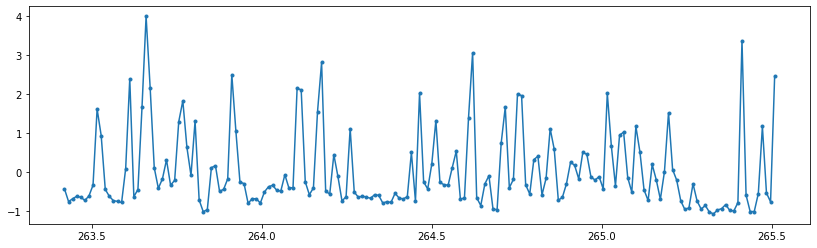

In [8]:
%matplotlib inline
plt.figure(figsize=(14,4))
# plt.plot(data_CuAl[:,0], data_CuAl[:,1], '.-')
plt.plot(depth ,y, '.-')


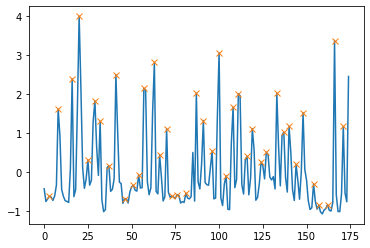

In [30]:
from scipy.signal import find_peaks, peak_widths
peaks, _ = find_peaks(y, distance=3)
results_half = peak_widths(y, peaks, rel_height=0.5)
np.diff(peaks)
# array([186, 180, 177, 171, 177, 169, 167, 164, 158, 162, 172])

plt.plot(y)

plt.plot(peaks, y[peaks], "x")

plt.show()

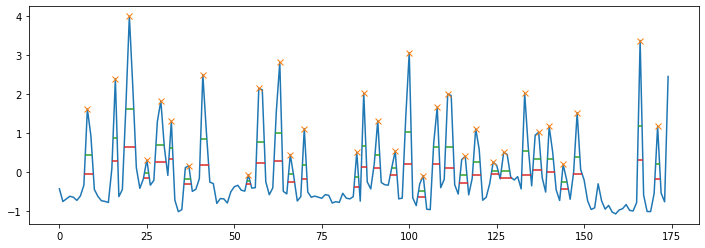

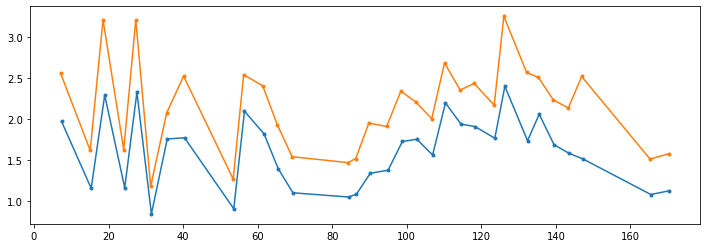

In [50]:
peaks, _ = find_peaks(y, height=-0.1)

results_half = peak_widths(y, peaks, rel_height=0.5)


results_full = peak_widths(y, peaks, rel_height=0.7)

plt.figure(figsize=(12,4))
plt.plot(y)

plt.plot(peaks, y[peaks], "x")

plt.hlines(*results_half[1:], color="C2")

plt.hlines(*results_full[1:], color="C3")

plt.figure(figsize=(12,4))
plt.plot(results_half[2], results_half[3]-results_half[2], '.-')
plt.plot(results_full[2], results_full[3]-results_full[2], '.-')



(array([ 0.43367478,  0.88454656,  1.61306863, -0.00992289,  0.70896996,
         0.61284175, -0.1643219 ,  0.85161393, -0.2386362 ,  0.78677047,
         1.01183674, -0.05459508,  0.18890503, -0.12027342,  0.67037875,
         0.44670451,  0.10241879,  1.02656334, -0.47547556,  0.6356524 ,
         0.64464174, -0.07773937,  0.26651689,  0.04171151,  0.0392898 ,
         0.53086725,  0.33771564,  0.33206233, -0.25037464,  0.399184  ,
         1.18435289,  0.20522671]),
 array([  7.39246046,  15.34331119,  18.97394249,  24.33634583,
         27.61081086,  31.5       ,  35.74135151,  40.38192942,
         53.59281103,  56.46444707,  61.72470202,  65.5       ,
         69.46883487,  84.44959721,  86.51041273,  90.21155772,
         94.97957322,  98.81994243, 102.69044677, 106.93613771,
        110.37794793, 114.54886638, 118.33357757, 123.61117505,
        126.31192065, 132.39159978, 135.53048039, 139.5       ,
        143.51715306, 147.25714486, 165.47233572, 170.43872266]),
 array([  9.

# Model

In [9]:
coef_time = 1e6
arcsec_to_pi = 1/180/3600*np.pi

b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.022 #
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
phi_k = phi_k/180/3600*np.pi
muy_k = muy_k/180/3600*np.pi*coef_time

p0 = 50.467718
# p0 = 40
p0 = p0/180/3600*np.pi*coef_time

# b_k

ordering = [4, 1, 3, 2, 0]
b_k = b_k[ordering]
g_k = muy_k[ordering]
phi_k = phi_k[ordering]


# fe_k = np.array([3.199279, 13.651920, 10.456224, 13.109803, 9.909679])
# fe_k = fe_k/180/3600*np.pi*coef_time

fe_k =  np.array([g_k[1]-g_k[4], g_k[3]-g_k[4] , g_k[3]-g_k[1], g_k[2]-g_k[4], g_k[2]-g_k[1]])

fs = np.hstack([g_k + p0, fe_k])
print(fs)
print(2*np.pi/fs)

[271.72398927 280.82533348 328.87002991 331.50547223 265.31565416
  15.50967932  66.18981807  50.68013875  63.55437575  48.04469643]
[0.02312341 0.022374   0.01910538 0.01895349 0.02368192 0.40511381
 0.09492677 0.12397727 0.09886314 0.13077792]


In [181]:
print(2*np.pi/ np.hstack([g_k + 90/180/3600*np.pi*coef_time])*1e3)

[13.55941027 13.29821824 12.07079353 12.00998675 13.74955966]


## Constant SR

In [133]:
n, m = 100, 100
p0_grid = np.linspace(50,100,n)
p0_grid = p0_grid*1/180/3600*np.pi*coef_time
invSR_grid = np.linspace(0.01, 0.5, m)
p0_mg, invSR_mg = np.meshgrid(p0_grid, invSR_grid)
depth_total = depth[-1] - depth[0]
T_grid = invSR_grid*(depth[-1]-depth[0])
p0_mg, T_mg = np.meshgrid(p0_grid, invSR_grid)
r2_grid = np.zeros((m, n))

In [134]:

for i in range(n):
    for j in range(m):
        # i, j = 0, 0
        p0_i, invSR_i = p0_mg[j,i] , invSR_mg[j,i]

        reg = linear_model.LinearRegression()
        # X = generate_X_linReg(np.ones_like(fe_k), fe_k, times_true)

        fs = np.hstack([g_k + p0_i, fe_k])
        depth_genes = np.linspace(depth[0], depth[-1], 20)
        # func_inv_SR(depth_genes)
        invSR = np.ones_like(depth)*invSR_i
        timesx = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)
        dt = timesx[1]-timesx[0]
        f_sampling = 1/dt
        if (p0_i+g_k[3])/2/np.pi >= f_sampling/2:
            # print("aa")
            continue 
        # X = generate_X_linReg(np.ones_like(fs), fs, times_true)
        X = generate_X_linReg(np.ones_like(fs), fs, timesx)

        reg.fit(X, y)
        # reg.fit(X, y_model)

        y_pred = reg.predict(X)
        r2_grid[j,i] = r2_score(y, y_pred)
# print(r2_score(y_model, y_pred))
# y_true = X @ ABtrue
# y_pred = X @ reg.coef_
i_best, j_best = np.where(r2_grid==r2_grid.max())
invSR_grid[i_best], p0_grid[j_best]
print(r2_grid.max())

0.4020097785149459


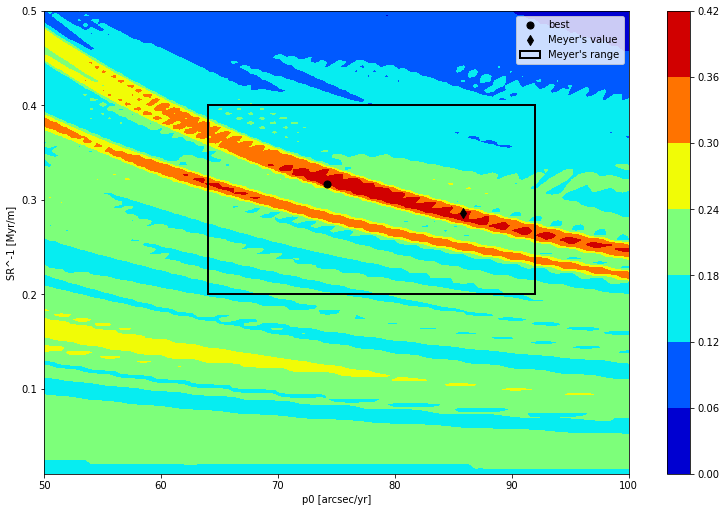

In [136]:
from matplotlib.patches import Rectangle
# plt.figure(figsize=(15,10))
fig, ax = plt.subplots(1,1, figsize=(10,7),constrained_layout=True)
plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2_grid, cmap=plt.cm.jet)
plt.colorbar()
plt.scatter(p0_grid[j_best]/(1/180/3600*np.pi*coef_time), invSR_grid[i_best], s=50, color="k", label="best")
plt.scatter(85.8, 1/3.5, marker="d", s=50, color="k",label="Meyer's value")
# plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2_grid)
# plt.xlabel("")
rect = Rectangle((78-14,0.2),14*2,0.2,linewidth=2,edgecolor='k',facecolor='none', label="Meyer's range")
ax.add_patch(rect)

plt.xlabel("p0 [arcsec/yr]")
plt.ylabel("SR^-1 [Myr/m]")
plt.legend()
# plt.ax
# plt.contour(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2_grid)
# plt.axis('scaled')
# plt.savefig("Xiamaling/constantSR.png",dpi=300)

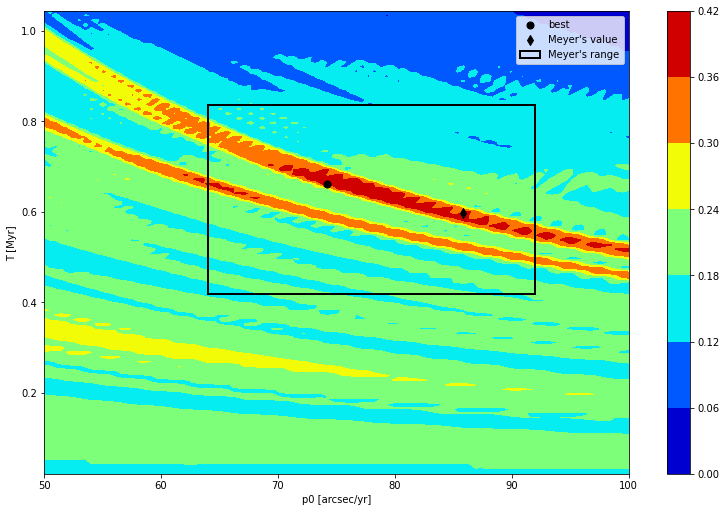

In [137]:
from matplotlib.patches import Rectangle
# plt.figure(figsize=(15,10))
fig, ax = plt.subplots(1,1, figsize=(10,7),constrained_layout=True)
plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), T_grid, r2_grid, cmap=plt.cm.jet)
plt.colorbar()
plt.scatter(p0_grid[j_best]/(1/180/3600*np.pi*coef_time), T_grid[i_best], s=50, color="k", label="best")
plt.scatter(85.8, 1/3.5*depth_total, marker="d", s=50, color="k",label="Meyer's value")
# plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2_grid)
# plt.xlabel("")
rect = Rectangle((78-14,0.2*depth_total),14*2,0.2*depth_total,linewidth=2,edgecolor='k',facecolor='none', label="Meyer's range")
ax.add_patch(rect)

plt.xlabel("p0 [arcsec/yr]")
plt.ylabel("T [Myr]")
plt.legend()
# plt.ax
# plt.contour(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2_grid)
# plt.axis('scaled')
# plt.savefig("Xiamaling/constantSR.png",dpi=300)

## With envelope

In [349]:
n, m = 100, 100
p0_grid = np.linspace(50,100,n)
p0_grid = p0_grid*1/180/3600*np.pi*coef_time
invSR_grid = np.linspace(0.1, 1, m)
p0_mg, invSR_mg = np.meshgrid(p0_grid, invSR_grid)


In [390]:

r2_grid = np.zeros((m, n))
r2_env_grid = np.zeros((m, n))
for i in range(n):
    for j in range(m):
        p0_i, invSR_i = p0_mg[j,i] , invSR_mg[j,i]
        reg = linear_model.LinearRegression()
        fs = np.hstack([g_k + p0_i, fe_k])
        invSR = np.ones_like(depth)*invSR_i
        timesx = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)
        dt = timesx[1]-timesx[0]
        X = generate_X_linReg(np.ones_like(fs), fs, timesx)
        reg.fit(X, y)
        y_pred = reg.predict(X)
        r2_grid[j,i] = r2_score(y, y_pred)
        f_sampling = 1/dt
        if p0_i/2/np.pi >= 1/dt/2:
            window_filter = [2*f_sampling/2 - p0_i/2/np.pi, min((p0_i+g_k[3]+g_k[0] )/2/np.pi, f_sampling/2-0.1)]
            # print(window_filter)
        else:
            window_filter = [p0_i/2/np.pi, min((p0_i+g_k[3]+g_k[0] )/2/np.pi, f_sampling/2-0.1)]
            # continue
        # window_filter = [p0_i/2/np.pi, min((p0_i+g_k[3]+g_k[0] )/2/np.pi, 1/dt/2-0.1)]
        sos = sp.signal.butter(10, window_filter, 'bandpass', output='sos' , fs=f_sampling)
        y_filtered = sp.signal.sosfiltfilt(sos, y)
        complex_y = sp.signal.hilbert(y_filtered)
        y_envelope = abs(complex_y)
        y_envelope = (y_envelope-y_envelope.mean())/y_envelope.std()
        X = generate_X_linReg(np.ones_like(fe_k), fe_k, timesx)
        reg.fit(X, y_envelope)
        y_env_pred = reg.predict(X)
        r2_env_grid[j,i] = r2_score(y_envelope, y_env_pred)
        
        
# print(r2_score(y_model, y_pred))
# y_true = X @ ABtrue
# y_pred = X @ reg.coef_
i_best, j_best = np.where(r2_grid==r2_grid.max())
invSR_grid[i_best], p0_grid[j_best]
print(r2_grid.max()), print(r2_env_grid.max())

0.45651387113762165
0.9992305250370367


(None, None)

In [ ]:
plt.contourf?

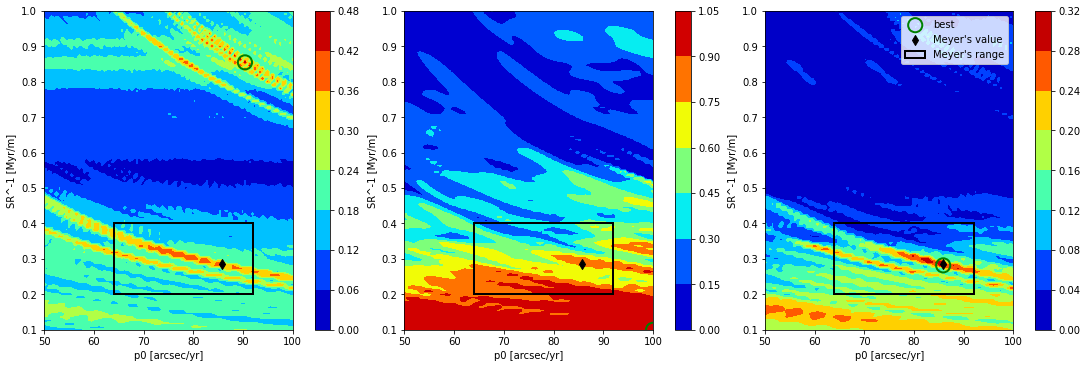

In [385]:
from matplotlib.patches import Rectangle
# plt.figure(figsize=(15,10))
fig, axs = plt.subplots(1, 3, figsize=(15,5),constrained_layout=True)
r2_comp = r2_grid*r2_env_grid
r2s = r2_grid, r2_env_grid, r2_comp

for i in range(3):
    ax = axs[i]
    i_best, j_best = np.where(r2s[i]==r2s[i].max())
    # print(r2_grid.max()), print(r2_env_grid.max())
    a = ax.contourf(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2s[i], cmap=plt.cm.jet)
    # plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2_env_grid, cmap=plt.cm.jet, vmin=0,vmax=r2_env_grid.max())

    plt.colorbar(a)
    ax.scatter(p0_grid[j_best]/(1/180/3600*np.pi*coef_time), invSR_grid[i_best], s=200, color="green", label="best",facecolors='none',linewidths=2)
    ax.scatter(85.8, 1/3.5, marker="d", s=50, color="k",label="Meyer's value")
    # plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2_grid)
    # plt.xlabel("")
    rect = Rectangle((78-14,0.2),14*2,0.2,linewidth=2,edgecolor='k',facecolor='none', label="Meyer's range")
    ax.add_patch(rect)

    ax.set_xlabel("p0 [arcsec/yr]")
    ax.set_ylabel("SR^-1 [Myr/m]")
plt.legend()
# plt.ax
# plt.contour(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2_grid)
# plt.axis('scaled')
# plt.savefig("Xiamaling/constantSR.png",dpi=300)

In [397]:
sos = sp.signal.butter(10, window_filter, 'bandpass', output='sos' , fs=1/dt)


TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable tan method

In [411]:
i,j=np.where(r2_comp==r2_comp.max())
p0_i, invSR_i = p0_grid[j] , invSR_grid[i]
reg = linear_model.LinearRegression()
fs = np.hstack([g_k + p0_i, fe_k])
invSR = np.ones_like(depth)*invSR_i
timesx = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)
dt = timesx[1]-timesx[0]
X = generate_X_linReg(np.ones_like(fs), fs, timesx)
reg.fit(X, y)
y_pred = reg.predict(X)
print(r2_score(y, y_pred))

# if p0_i/2/np.pi >= 1/dt/2:
#     continue
window_filter = [p0_i/2/np.pi, min((p0_i+g_k[3]+g_k[0] )/2/np.pi, 1/dt/2)]
sos = sp.signal.butter(10, window_filter, 'bandpass', output='sos' , fs=1/dt)
y_filtered = sp.signal.sosfiltfilt(sos, y)
complex_y = sp.signal.hilbert(y_filtered)
y_envelope = abs(complex_y)
y_envelope = (y_envelope-y_envelope.mean())/y_envelope.std()
X = generate_X_linReg(np.ones_like(fe_k), fe_k, timesx)
reg.fit(X, y_envelope)
y_env_pred = reg.predict(X)
print(r2_score(y_envelope, y_env_pred))

0.3768046921097
0.7870546801056345


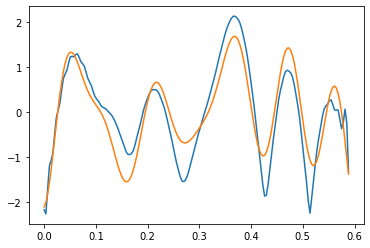

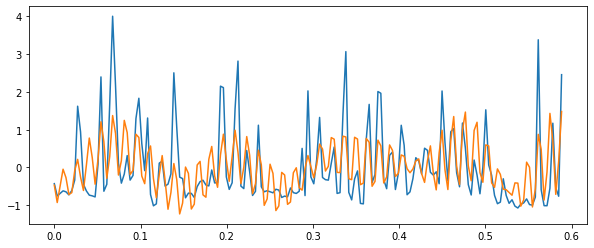

In [413]:
plt.figure()
plt.plot(timesx, y_envelope)
plt.plot(timesx, y_env_pred)
plt.figure(figsize=(10,4))
plt.plot(timesx, y)
plt.plot(timesx, y_pred)


# GA

## In search for optimal number of genes

In [7]:
invSR_lims = [0.01, 2]
fs = np.hstack([g_k + p0, fe_k])
# p0_lims = np.array([50, 120])/180/3600*np.pi*coef_time
# invSR_to_predx =  partial(invSR_to_pred,  data=[depth, y], invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)

# fsp = np.hstack([g_k, fe_k])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
invSR_to_predx =  partial(invSR_to_pred,  data=[depth, y], invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)
n_pieces = 2
# depth_genes = np.linspace(depth_lims[0], depth_lims[1], 100)
data = [depth, y]

array([2, 3, 4, 5])

In [11]:
algorithm = NSGA2(
    pop_size=300,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 400
termination = get_termination("n_gen", N_generations)

# N_genes_enemble = np.arange(10, 60, 4)
# N_genes_enemble = np.array([24]*10)
# depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
# N_ensemble = len(depth_genes_ensemble)

N_trial = 20
N_genes_distinct = np.arange(2, 7, 1)
N_genes_enemble = np.array([ np.array([i]*N_trial)  for i in  N_genes_distinct]).flatten()
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1],N_genes) for N_genes in N_genes_enemble] 

N_ensemble = len(depth_genes_ensemble)
print(N_ensemble)

problems = [invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=2, metric=metric_piecewise) for depth_genes in depth_genes_ensemble  ] 


res_ensemble = Parallel(n_jobs=N_ensemble, verbose=100)(delayed(minimize)(problem, algorithm, termination, 
                                                                          save_history=False, callback=Callback_getF())
                                                        for problem in problems)

100
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:  2.9min
[Parallel(n_jobs=100)]: Done   3 out of 100 | elapsed:  2.9min remaining: 93.8min
[Parallel(n_jobs=100)]: Done   5 out of 100 | elapsed:  2.9min remaining: 55.3min
[Parallel(n_jobs=100)]: Done   7 out of 100 | elapsed:  2.9min remaining: 38.8min
[Parallel(n_jobs=100)]: Done   9 out of 100 | elapsed:  2.9min remaining: 29.6min
[Parallel(n_jobs=100)]: Done  11 out of 100 | elapsed:  2.9min remaining: 23.7min
[Parallel(n_jobs=100)]: Done  13 out of 100 | elapsed:  2.9min remaining: 19.6min
[Parallel(n_jobs=100)]: Done  15 out of 100 | elapsed:  2.9min remaining: 16.7min
[Parallel(n_jobs=100)]: Done  17 out of 100 | elapsed:  2.9min remaining: 14.4min
[Parallel(n_jobs=100)]: Done  19 out of 100 | elapsed:  2.9min remaining: 12.6min
[Parallel(n_jobs=100)]: Done  21 out of 100 | elapsed:  3.0min remaining: 11.1min
[Parallel(n_jobs=100)]: Done  23 o

/tmp/ipykernel_2733128/1905593840.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Text(0, 0.5, 'r2')

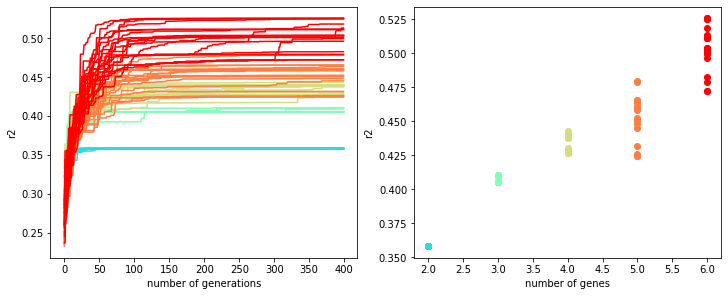

In [12]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))


# metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], fs, interpolator, n_pieces)
plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.55])
# plt.axhline(metric_optimal.mean(), color="k")

# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
# [ for i in range(N_ensemble)]
for i in range(N_ensemble):
    plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    # metric_optimal = metric_piecewise([depth_genes_ensemble[i], func_inv_SR(depth_genes_ensemble[i])], [depth, y], fs, interpolator, n_pieces)
    # plt.axhline(metric_optimal.mean() , color=cmap(i/N_ensemble),zorder=-10)
# plt.axhline(metric_optimal.mean(), color="k")

plt.xlabel("number of genes")
plt.ylabel("r2")
# plt.ylim([0.1, 0.55])
# plt.savefig("r2_Ngenesb.png", dpi=200)


# fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
# cmap = plt.get_cmap("rainbow")
# rho = 0.8
# sigma = 0.8
# for i, res in enumerate(res_ensemble):
#     res = res_ensemble[i]
#     # if i<=40:
#     #     continue
#     depth_genes = depth_genes_ensemble[i]
#     arg_best = np.argmin(res.F.sum(axis=1))
#     # maxlogL  = log_likelihood_rednoise([depth_genes, func_inv_SR(depth_genes)], data, fs, [rho_true, sigma_true], interpolator=interpolate_CubicSpline)
#     maxlogL  = log_likelihood_rednoise([depth_genes, res.X[arg_best]], data, fs, [sigma, rho], interpolator=interpolate_CubicSpline)

#     # plt.scatter(N_genes_enemble[i], maxlogL, color=cmap(i/N_ensemble))
#     axs[0].scatter(N_genes_enemble[i], maxlogL_to_BIC(maxlogL, N_genes_enemble[i], len(y)), color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
#     axs[1].scatter(N_genes_enemble[i], maxlogL_to_AIC(maxlogL, N_genes_enemble[i]), color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))

[0.68176806 0.469486  ]


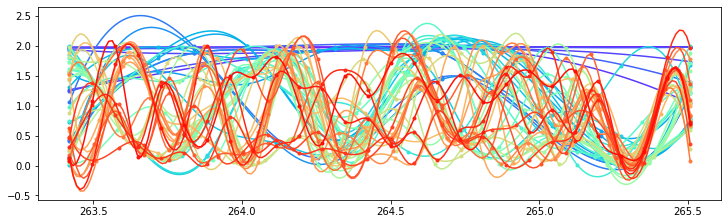

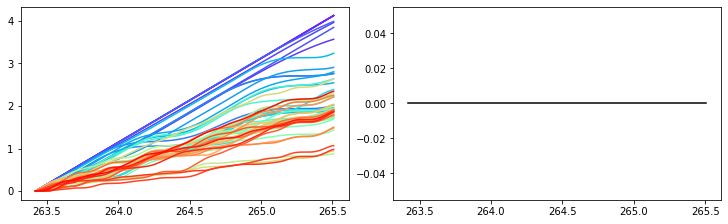

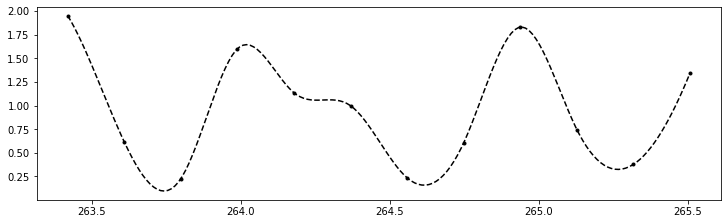

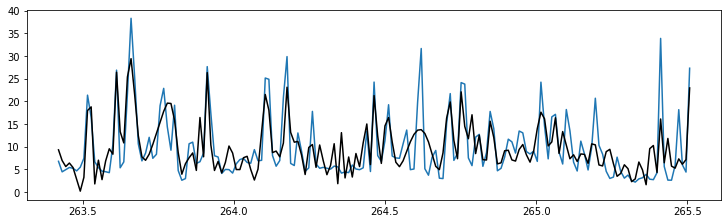

In [64]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
    # axs[1].plot(depth, time-func_time_nominal(depth)+func_time_nominal(depth[0]), color=cmap(i/N_ensemble))
# axs[0].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]), color="black")
axs[1].plot(depth, depth*0, color="k")

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black")
i = 20
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best], '.', color="black")
# ax.set_ylim(invSR_lims)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
ax.plot(depth, y )
ax.plot(depth, y_pred, color="black")

# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

### With p0 as variable

In [38]:
invSR_lims = [0.01, 3]
p0_lims = np.array([50, 120])/180/3600*np.pi*coef_time

fsp = np.hstack([g_k, fe_k])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
# invSR_to_predx =  partial(invSR_to_pred,  data=[depth, y], invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)
n_pieces = 2
data = depth, y

#### Test 1

In [54]:
algorithm = NSGA2(
    pop_size=300,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 400
termination = get_termination("n_gen", N_generations)

# N_genes_enemble = np.arange(10, 60, 4)
# N_genes_enemble = np.array([24]*500)
# depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
# N_ensemble = len(depth_genes_ensemble)
# fsp = np.hstack([g_k, fe_k])

N_trial = 20
N_genes_distinct = np.arange(1,7)
N_genes_enemble = np.array([ np.array([i]*N_trial)  for i in  N_genes_distinct]).flatten()
# N_genes_enemble = np.array([1]*10)
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1],N_genes) for N_genes in N_genes_enemble] 

N_ensemble = len(depth_genes_ensemble)


problems = [invSR_p0_inference(depth_genes, invSR_lims, p0_lims, interpolator, data, fsp, n_pieces=n_pieces, metric=metric_piecewise) for depth_genes in depth_genes_ensemble  ] 

n_procs = len(problems)
# n_procs = 64

res_ensemble = Parallel(n_jobs=n_procs, verbose=100)(delayed(minimize)(problem, algorithm, termination, 
                                                                          save_history=False, callback=Callback_getF())
                                                        for problem in problems)

# opt_max_ensemble = np.zeros([N_ensemble,N_generations])
# for i in range(N_ensemble):
#     res = res_ensemble[i]
#     opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])
# ind_sort = np.argsort(opt_max_ensemble[:,-1])
# res_ensemble = [res_ensemble[i] for i in  ind_sort]
# opt_max_ensemble = opt_max_ensemble[ind_sort]

[Parallel(n_jobs=120)]: Using backend LokyBackend with 120 concurrent workers.


[Parallel(n_jobs=120)]: Done   1 tasks      | elapsed:  2.7min
[Parallel(n_jobs=120)]: Done   3 out of 120 | elapsed:  3.0min remaining: 116.9min
[Parallel(n_jobs=120)]: Done   5 out of 120 | elapsed:  3.1min remaining: 70.9min
[Parallel(n_jobs=120)]: Done   7 out of 120 | elapsed:  3.1min remaining: 50.4min
[Parallel(n_jobs=120)]: Done   9 out of 120 | elapsed:  3.2min remaining: 39.5min
[Parallel(n_jobs=120)]: Done  11 out of 120 | elapsed:  3.3min remaining: 33.1min
[Parallel(n_jobs=120)]: Done  13 out of 120 | elapsed:  3.4min remaining: 27.7min
[Parallel(n_jobs=120)]: Done  15 out of 120 | elapsed:  3.4min remaining: 24.0min
[Parallel(n_jobs=120)]: Done  17 out of 120 | elapsed:  3.6min remaining: 21.5min
[Parallel(n_jobs=120)]: Done  19 out of 120 | elapsed:  3.6min remaining: 19.4min
[Parallel(n_jobs=120)]: Done  21 out of 120 | elapsed:  3.7min remaining: 17.3min
[Parallel(n_jobs=120)]: Done  23 out of 120 | elapsed:  3.7min remaining: 15.5min
[Parallel(n_jobs=120)]: Done  25 o

/tmp/ipykernel_2733128/1304329776.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


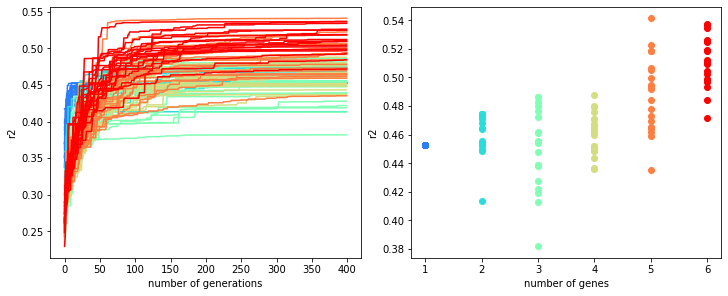

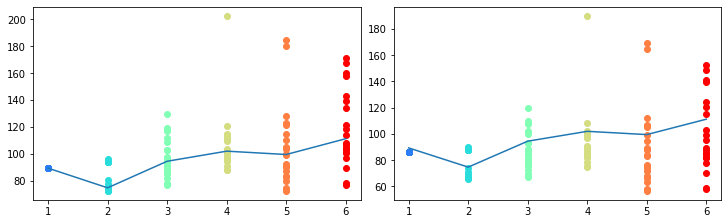

In [69]:
def maxlogL_to_BIC(maxlogL, n_params, n_data):
    return n_params*np.log(n_data) - 2*maxlogL
def maxlogL_to_AIC(maxlogL, n_params):
    return n_params*2 - 2*maxlogL
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))


# metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], fs, interpolator, n_pieces)
plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.55])
# plt.axhline(metric_optimal.mean(), color="k")

# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
# [ for i in range(N_ensemble)]
for i in range(N_ensemble):
    plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    # metric_optimal = metric_piecewise([depth_genes_ensemble[i], func_inv_SR(depth_genes_ensemble[i])], [depth, y], fs, interpolator, n_pieces)
    # plt.axhline(metric_optimal.mean() , color=cmap(i/N_ensemble),zorder=-10)
# plt.axhline(metric_optimal.mean(), color="k")

plt.xlabel("number of genes")
plt.ylabel("r2")
# plt.ylim([0.1, 0.55])
# plt.savefig("r2_Ngenesb.png", dpi=200)


fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
rho = 0.5
sigma = 0.8
BICs = np.zeros(len(res_ensemble))
AICs = np.zeros(len(res_ensemble))

for i, res in enumerate(res_ensemble):
    res = res_ensemble[i]
    # if i<=40:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    # maxlogL  = log_likelihood_rednoise([depth_genes, func_inv_SR(depth_genes)], data, fs, [rho_true, sigma_true], interpolator=interpolate_CubicSpline)
    maxlogL  = log_likelihood_rednoise([depth_genes, res.X[arg_best,1:]], data, np.hstack([g_k+res.X[arg_best,0], fe_k]), [sigma, rho], interpolator=interpolate_CubicSpline)

    BICs[i] = maxlogL_to_BIC(maxlogL, N_genes_enemble[i], len(y))
    AICs[i] = maxlogL_to_AIC(maxlogL, N_genes_enemble[i])
    # plt.scatter(N_genes_enemble[i], maxlogL, color=cmap(i/N_ensemble))
    axs[0].scatter(N_genes_enemble[i], BICs[i], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    axs[1].scatter(N_genes_enemble[i], AICs[i], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
BICs = np.reshape(BICs, (-1, N_trial))
AICs = np.reshape(BICs, (-1,N_trial))
axs[0].plot(N_genes_distinct, np.median(BICs, axis=-1))
axs[1].plot(N_genes_distinct, np.median(AICs, axis=-1))

In [66]:
BICs.shape

(6, 20)

/tmp/ipykernel_290110/4030433370.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


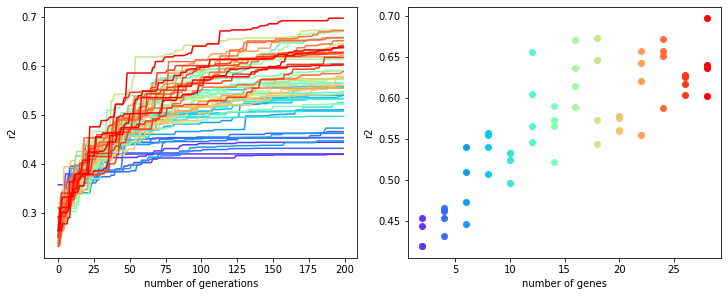

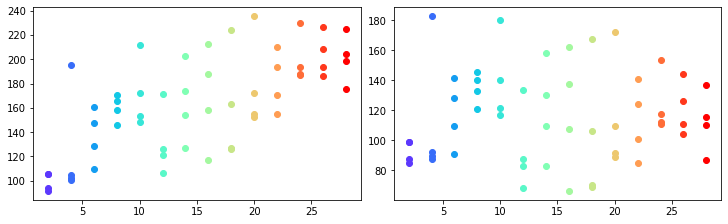

In [103]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))


# metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], fs, interpolator, n_pieces)
plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.55])
# plt.axhline(metric_optimal.mean(), color="k")

# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
# [ for i in range(N_ensemble)]
for i in range(N_ensemble):
    plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    # metric_optimal = metric_piecewise([depth_genes_ensemble[i], func_inv_SR(depth_genes_ensemble[i])], [depth, y], fs, interpolator, n_pieces)
    # plt.axhline(metric_optimal.mean() , color=cmap(i/N_ensemble),zorder=-10)
# plt.axhline(metric_optimal.mean(), color="k")

plt.xlabel("number of genes")
plt.ylabel("r2")
# plt.ylim([0.1, 0.55])
# plt.savefig("r2_Ngenesb.png", dpi=200)


fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
rho = 0.5
sigma = 0.8
for i, res in enumerate(res_ensemble):
    res = res_ensemble[i]
    # if i<=40:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    # maxlogL  = log_likelihood_rednoise([depth_genes, func_inv_SR(depth_genes)], data, fs, [rho_true, sigma_true], interpolator=interpolate_CubicSpline)
    maxlogL  = log_likelihood_rednoise([depth_genes, res.X[arg_best,1:]], data, np.hstack([g_k+res.X[arg_best,0], fe_k]), [sigma, rho], interpolator=interpolate_CubicSpline)

    # plt.scatter(N_genes_enemble[i], maxlogL, color=cmap(i/N_ensemble))
    axs[0].scatter(N_genes_enemble[i], maxlogL_to_BIC(maxlogL, N_genes_enemble[i], len(y)), color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    axs[1].scatter(N_genes_enemble[i], maxlogL_to_AIC(maxlogL, N_genes_enemble[i]), color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))

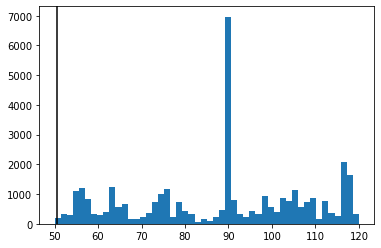

In [70]:
%matplotlib inline
# p0_ensemble = np.hstack([resi.X[:,0] for resi in res_ensemble[-4:] ])
# p0_ensemble.shape
# plt.hist(p0_ensemble/arcsec_to_pi/1e3)
plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[:] ])/arcsec_to_pi/1e6, bins=50)
# plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[-10:] ])/arcsec_to_pi/1e6, bins=10)
plt.axvline(p0/arcsec_to_pi/1e6, color="black")
# plt.xlim(*p0_lims/arcsec_to_pi/1e3)
# plt.xlim([45,55])

90.50476564193545 50.467717
[0.48429308 0.42164698]
0.4414414453623885


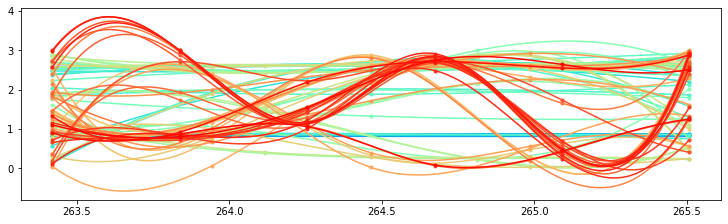

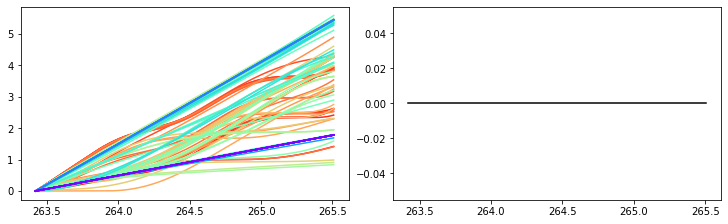

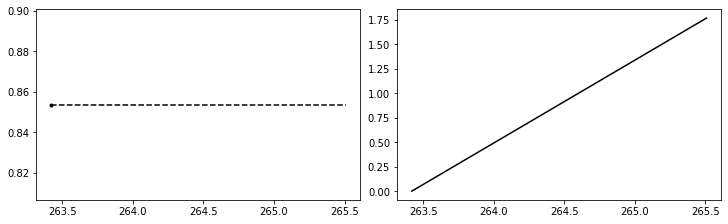

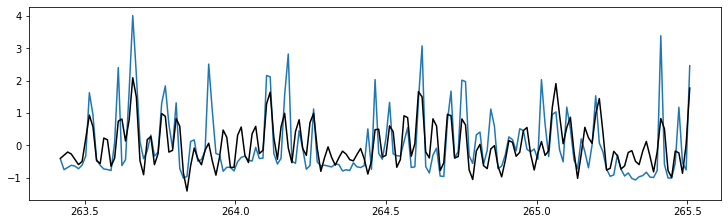

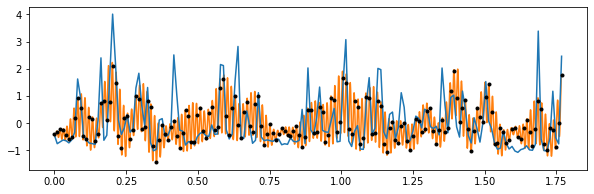

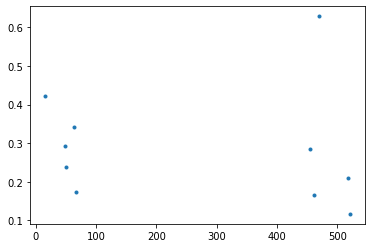

In [190]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best,1:], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
for i, res in enumerate(res_ensemble):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)

    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])

    axs[0].plot(depth, time, color=cmap(i/N_ensemble),zorder=-i)
#     axs[1].plot(depth, time-func_time_nominal(depth)+func_time_nominal(depth[0]), color=cmap(i/N_ensemble))
# axs[0].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]), color="black")
axs[1].plot(depth, depth*0, color="k")

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black")
# i = -15
i = 12
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]

# invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
# time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])
time, y_pred, coefs =  invSR_to_pred_v2([depth_genes, res.X[arg_best,1:]], data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
fs=np.hstack([g_k+res.X[arg_best,0], fe_k])
arg_best = np.argmin(res.F.mean(axis=1))
print(res.X[arg_best,0]/arcsec_to_pi/1e6, p0//arcsec_to_pi/1e6)
ax = axs[0]
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best,1:], '.', color="black")
# ax.set_ylim(invSR_lims)
axs[1].plot(depth, time, color="k")

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

ax.plot(depth, y )
ax.plot(depth, y_pred, color="black")
time_hr  = np.linspace(time[0],time[-1],10000)
Xx = generate_X_linReg(np.ones_like(fs), fs, time_hr)
y_pred_hr = Xx@coefs
plt.figure(figsize=(10,3))
plt.plot(time, y)
plt.plot(time, y_pred, ".",color="black")
plt.plot(time_hr, y_pred_hr,zorder=-1)
print(r2_score(y, y_pred))
plt.figure()
amp = np.sqrt(coefs[:len(fs)]**2 + coefs[len(fs):]**2)
plt.plot(fs, amp,'.')
# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

In [186]:
Xx = generate_X_linReg(np.ones_like(fs), fs, np.linspace(time[0],time[-1],10000))
y_pred = Xx@coefs

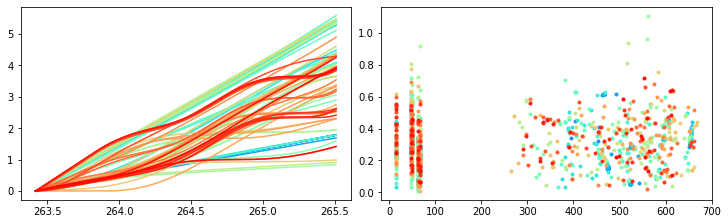

In [121]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
for i, res in enumerate(res_ensemble):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    time, y_pred, coefs =  invSR_to_pred_v2([depth_genes, res.X[arg_best,1:]], data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
    fs = np.hstack([g_k+res.X[arg_best,0], fe_k])
    # time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])

    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
    amp = np.sqrt(coefs[:len(fs)]**2 + coefs[len(fs):]**2)
    axs[1].plot(fs, amp,'.', color=cmap(i/N_ensemble))

    # axs[1].plot(depth, depth*0, color="k")
#     axs[1].plot(depth, time-func_time_nominal(depth)+func_time_nominal(depth[0]), color=cmap(i/N_ensemble))
# axs[0].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]), color="black")


#### Test 2
With constraint on invSR 

In [112]:
invSR_lims = [0.01, 3]
p0_lims = np.array([50, 120])/180/3600*np.pi*coef_time

fsp = np.hstack([g_k, fe_k])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
# invSR_to_predx =  partial(invSR_to_pred,  data=[depth, y], invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)
n_pieces = 2
data = depth, y

In [113]:
N_genes = 22 # number of intial gene in an individial of the population 
depth_lims = depth[0], depth[-1]
depth_genes = np.linspace(*depth_lims, N_genes)
genes_test =  np.ones_like(depth_genes)*0.7
invSR_lims = [0, 2]
# fs = np.hstack([g_k + p0, fe_k])

interpolator = interpolate_CubicSpline
n_pieces = 2

interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSR_p0_inference_constrained(depth_genes, invSR_lims, p0_lims, interpolator, data, fsp, n_pieces=n_pieces, metric=metric_piecewise_short)
out = {}
problem._evaluate(np.hstack([p0, genes_test]), out)
out

{'F': array([-0.12243338, -0.04778262]), 'G': [-9.884910355556698]}

In [114]:
algorithm = NSGA2(
    pop_size=300,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 400
termination = get_termination("n_gen", N_generations)

# N_genes_enemble = np.arange(10, 60, 4)
# N_genes_enemble = np.array([24]*500)
# depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
# N_ensemble = len(depth_genes_ensemble)
# fsp = np.hstack([g_k, fe_k])

N_trial = 20
N_genes_distinct = np.arange(1,7)
N_genes_enemble = np.array([ np.array([i]*N_trial)  for i in  N_genes_distinct]).flatten()
# N_genes_enemble = np.array([1]*10)
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1],N_genes) for N_genes in N_genes_enemble] 

N_ensemble = len(depth_genes_ensemble)


problems = [invSR_p0_inference_constrained(depth_genes, invSR_lims, p0_lims, interpolator, data, fsp, n_pieces=n_pieces, metric=metric_piecewise_short) for depth_genes in depth_genes_ensemble  ] 

n_procs = len(problems)
# n_procs = 64

res_ensemble = Parallel(n_jobs=n_procs, verbose=100)(delayed(minimize)(problem, algorithm, termination, 
                                                                          save_history=False, callback=Callback_getF())
                                                        for problem in problems)

# opt_max_ensemble = np.zeros([N_ensemble,N_generations])
# for i in range(N_ensemble):
#     res = res_ensemble[i]
#     opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])
# ind_sort = np.argsort(opt_max_ensemble[:,-1])
# res_ensemble = [res_ensemble[i] for i in  ind_sort]
# opt_max_ensemble = opt_max_ensemble[ind_sort]

[Parallel(n_jobs=120)]: Using backend LokyBackend with 120 concurrent workers.


[Parallel(n_jobs=120)]: Done   1 tasks      | elapsed:  3.1min
[Parallel(n_jobs=120)]: Done   3 out of 120 | elapsed:  3.2min remaining: 124.8min
[Parallel(n_jobs=120)]: Done   5 out of 120 | elapsed:  3.4min remaining: 77.2min
[Parallel(n_jobs=120)]: Done   7 out of 120 | elapsed:  3.6min remaining: 58.4min
[Parallel(n_jobs=120)]: Done   9 out of 120 | elapsed:  3.8min remaining: 46.4min
[Parallel(n_jobs=120)]: Done  11 out of 120 | elapsed:  3.8min remaining: 37.7min
[Parallel(n_jobs=120)]: Done  13 out of 120 | elapsed:  3.8min remaining: 31.6min
[Parallel(n_jobs=120)]: Done  15 out of 120 | elapsed:  3.8min remaining: 26.9min
[Parallel(n_jobs=120)]: Done  17 out of 120 | elapsed:  3.8min remaining: 23.3min
[Parallel(n_jobs=120)]: Done  19 out of 120 | elapsed:  3.9min remaining: 20.5min
[Parallel(n_jobs=120)]: Done  21 out of 120 | elapsed:  3.9min remaining: 18.3min
[Parallel(n_jobs=120)]: Done  23 out of 120 | elapsed:  3.9min remaining: 16.4min
[Parallel(n_jobs=120)]: Done  25 o

/tmp/ipykernel_1904609/838992587.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


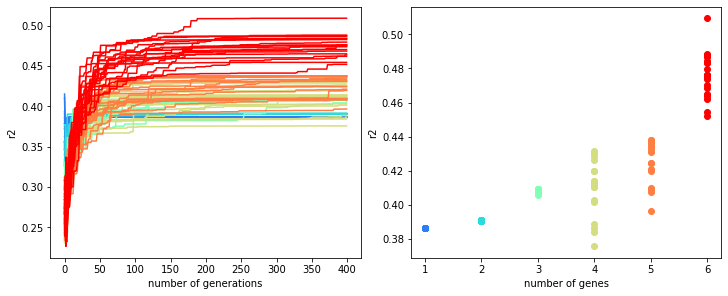

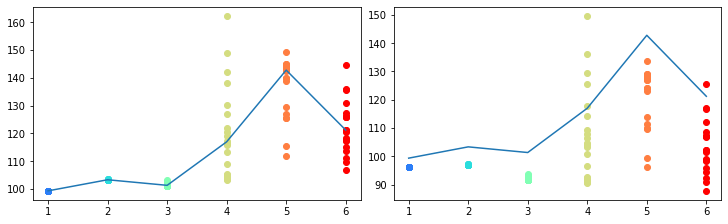

In [115]:
def maxlogL_to_BIC(maxlogL, n_params, n_data):
    return n_params*np.log(n_data) - 2*maxlogL
def maxlogL_to_AIC(maxlogL, n_params):
    return n_params*2 - 2*maxlogL
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))


# metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], fs, interpolator, n_pieces)
plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.55])
# plt.axhline(metric_optimal.mean(), color="k")

# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
# [ for i in range(N_ensemble)]
for i in range(N_ensemble):
    plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    # metric_optimal = metric_piecewise([depth_genes_ensemble[i], func_inv_SR(depth_genes_ensemble[i])], [depth, y], fs, interpolator, n_pieces)
    # plt.axhline(metric_optimal.mean() , color=cmap(i/N_ensemble),zorder=-10)
# plt.axhline(metric_optimal.mean(), color="k")

plt.xlabel("number of genes")
plt.ylabel("r2")
# plt.ylim([0.1, 0.55])
# plt.savefig("r2_Ngenesb.png", dpi=200)


fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
rho = 0.5
sigma = 0.8
BICs = np.zeros(len(res_ensemble))
AICs = np.zeros(len(res_ensemble))

for i, res in enumerate(res_ensemble):
    res = res_ensemble[i]
    # if i<=40:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    # maxlogL  = log_likelihood_rednoise([depth_genes, func_inv_SR(depth_genes)], data, fs, [rho_true, sigma_true], interpolator=interpolate_CubicSpline)
    maxlogL  = log_likelihood_rednoise([depth_genes, res.X[arg_best,1:]], data, np.hstack([g_k+res.X[arg_best,0], fe_k]), [sigma, rho], interpolator=interpolate_CubicSpline)

    BICs[i] = maxlogL_to_BIC(maxlogL, N_genes_enemble[i], len(y))
    AICs[i] = maxlogL_to_AIC(maxlogL, N_genes_enemble[i])
    # plt.scatter(N_genes_enemble[i], maxlogL, color=cmap(i/N_ensemble))
    axs[0].scatter(N_genes_enemble[i], BICs[i], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    axs[1].scatter(N_genes_enemble[i], AICs[i], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
BICs = np.reshape(BICs, (-1, N_trial))
AICs = np.reshape(BICs, (-1,N_trial))
axs[0].plot(N_genes_distinct, np.median(BICs, axis=-1))
axs[1].plot(N_genes_distinct, np.median(AICs, axis=-1))

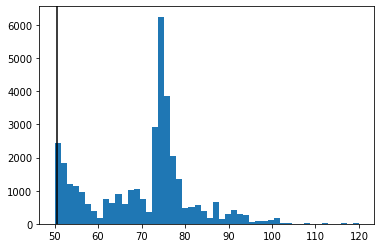

In [116]:
%matplotlib inline
# p0_ensemble = np.hstack([resi.X[:,0] for resi in res_ensemble[-4:] ])
# p0_ensemble.shape
# plt.hist(p0_ensemble/arcsec_to_pi/1e3)
plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[:] ])/arcsec_to_pi/1e6, bins=50)
# plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[-10:] ])/arcsec_to_pi/1e6, bins=10)
plt.axvline(p0/arcsec_to_pi/1e6, color="black")
# plt.xlim(*p0_lims/arcsec_to_pi/1e3)
# plt.xlim([45,55])

75.00707237333287 50.467717
[0.35806334 0.41526067]
0.38037839399776674


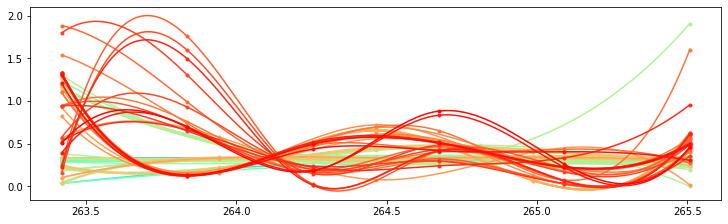

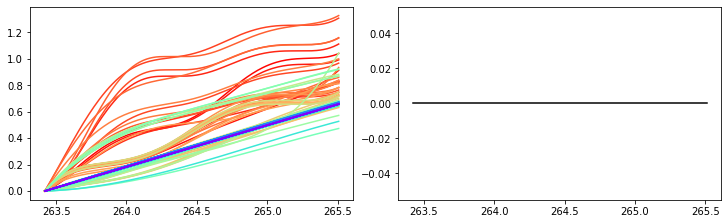

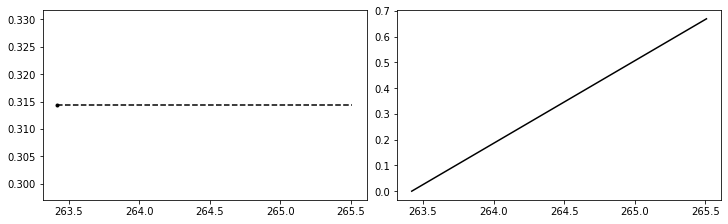

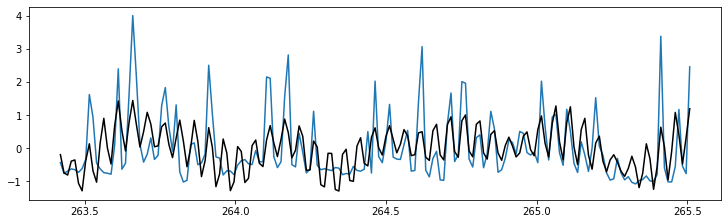

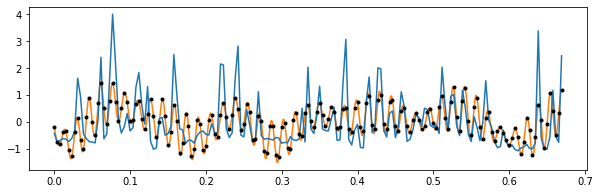

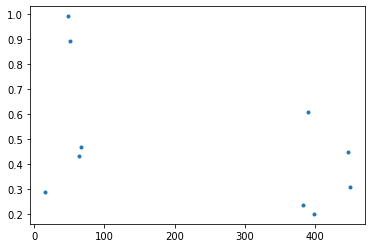

In [55]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best,1:], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
for i, res in enumerate(res_ensemble):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)

    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])

    axs[0].plot(depth, time, color=cmap(i/N_ensemble),zorder=-i)
#     axs[1].plot(depth, time-func_time_nominal(depth)+func_time_nominal(depth[0]), color=cmap(i/N_ensemble))
# axs[0].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]), color="black")
axs[1].plot(depth, depth*0, color="k")

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black")
# i = -15
i = 12
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]

# invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
# time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])
time, y_pred, coefs =  invSR_to_pred_v2([depth_genes, res.X[arg_best,1:]], data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
fs=np.hstack([g_k+res.X[arg_best,0], fe_k])
arg_best = np.argmin(res.F.mean(axis=1))
print(res.X[arg_best,0]/arcsec_to_pi/1e6, p0//arcsec_to_pi/1e6)
ax = axs[0]
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best,1:], '.', color="black")
# ax.set_ylim(invSR_lims)
axs[1].plot(depth, time, color="k")

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

ax.plot(depth, y )
ax.plot(depth, y_pred, color="black")
time_hr  = np.linspace(time[0],time[-1],10000)
Xx = generate_X_linReg(np.ones_like(fs), fs, time_hr)
y_pred_hr = Xx@coefs
plt.figure(figsize=(10,3))
plt.plot(time, y)
plt.plot(time, y_pred, ".",color="black")
plt.plot(time_hr, y_pred_hr,zorder=-1)
print(r2_score(y, y_pred))
plt.figure()
amp = np.sqrt(coefs[:len(fs)]**2 + coefs[len(fs):]**2)
plt.plot(fs, amp,'.')
# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

## fixed number of genes

In [11]:
invSR_lims = [0.01, 2]
p0_lims = np.array([50, 120])/180/3600*np.pi*coef_time

fsp = np.hstack([g_k, fe_k])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
# invSR_to_predx =  partial(invSR_to_pred,  data=[depth, y], invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)
n_pieces = 2
data = depth, y

### test 1

In [13]:
algorithm = NSGA2(
    pop_size=200,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 400
termination = get_termination("n_gen", N_generations)

# N_genes_enemble = np.arange(10, 60, 4)
N_genes_enemble = np.array([6]*64)
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
N_ensemble = len(depth_genes_ensemble)
fsp = np.hstack([g_k, fe_k])

# N_trial = 4
# N_genes_distinct = np.arange(2, 60, 2)
# N_genes_enemble = np.array([ np.array([i]*N_trial)  for i in  N_genes_distinct]).flatten()
# depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1],N_genes) for N_genes in N_genes_enemble] 

# N_ensemble = len(depth_genes_ensemble)


problems = [invSR_p0_inference(depth_genes, invSR_lims, p0_lims, interpolator, data, fsp, n_pieces=n_pieces, metric=metric_piecewise) for depth_genes in depth_genes_ensemble  ] 

n_procs = len(problems)
# n_procs = 64

res_ensemble = Parallel(n_jobs=n_procs, verbose=100)(delayed(minimize)(problem, algorithm, termination, 
                                                                          save_history=False, callback=Callback_getF())
                                                        for problem in problems)

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])
ind_sort = np.argsort(opt_max_ensemble[:,-1])
res_ensemble = [res_ensemble[i] for i in  ind_sort]
opt_max_ensemble = opt_max_ensemble[ind_sort]

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done   2 out of  64 | elapsed:  4.1min remaining: 125.7min
[Parallel(n_jobs=64)]: Done   3 out of  64 | elapsed:  4.8min remaining: 97.7min
[Parallel(n_jobs=64)]: Done   4 out of  64 | elapsed:  5.0min remaining: 74.4min
[Parallel(n_jobs=64)]: Done   5 out of  64 | elapsed:  5.9min remaining: 69.4min
[Parallel(n_jobs=64)]: Done   6 out of  64 | elapsed:  6.0min remaining: 58.2min
[Parallel(n_jobs=64)]: Done   7 out of  64 | elapsed:  6.2min remaining: 50.2min
[Parallel(n_jobs=64)]: Done   8 out of  64 | elapsed:  6.2min remaining: 43.5min
[Parallel(n_jobs=64)]: Done   9 out of  64 | elapsed:  6.2min remaining: 38.0min
[Parallel(n_jobs=64)]: Done  10 out of  64 | elapsed:  6.2min remaining: 33.6min
[Parallel(n_jobs=64)]: Done  11 out of  64 | elapsed:  6.3min remaining: 30.3min
[Parallel(n_jobs=64)]: Done  12 out of  64 | elaps

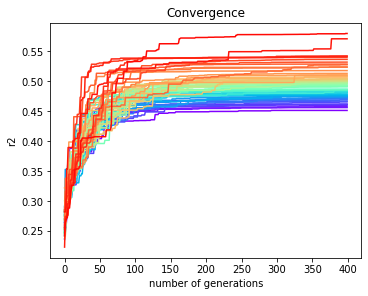

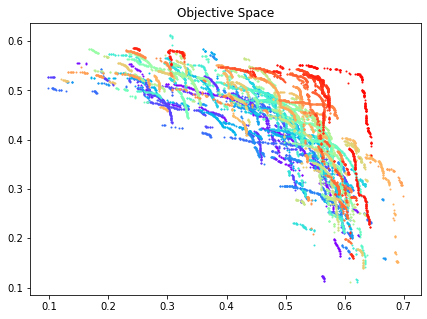

In [14]:

# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(5,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
# plt.subplot(1,1,1)

cmap = plt.get_cmap("rainbow")

for i in range(N_ensemble):

    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))


plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.8])
# plt.axhline(metric_optimal.mean(), color="k")


plt.figure(figsize=(7, 5))

for i in range(N_ensemble):
    res = res_ensemble[i]
    plt.scatter(-res.F[:, 0], -res.F[:, 1], s=1, color=cmap(i/N_ensemble))
f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)
# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


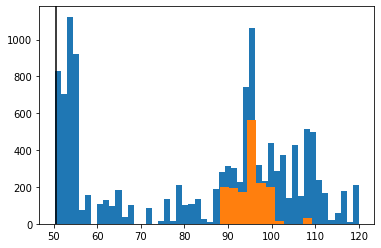

In [20]:
%matplotlib inline
# p0_ensemble = np.hstack([resi.X[:,0] for resi in res_ensemble[-4:] ])
# p0_ensemble.shape
# plt.hist(p0_ensemble/arcsec_to_pi/1e3)
plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[:] ])/arcsec_to_pi/1e6, bins=50)
plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[-8:] ])/arcsec_to_pi/1e6, bins=10)
plt.axvline(p0/arcsec_to_pi/1e6, color="black")
# plt.xlim(*p0_lims/arcsec_to_pi/1e3)
# plt.xlim([45,55])

94.64209069941148 50.467717
[0.5552146 0.5280203]
0.5317890489144936


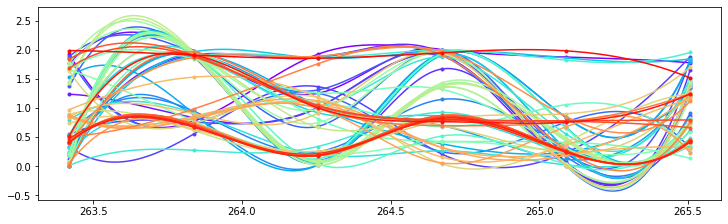

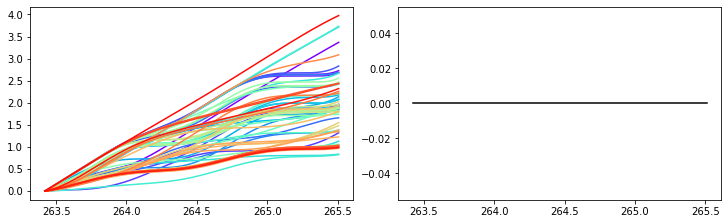

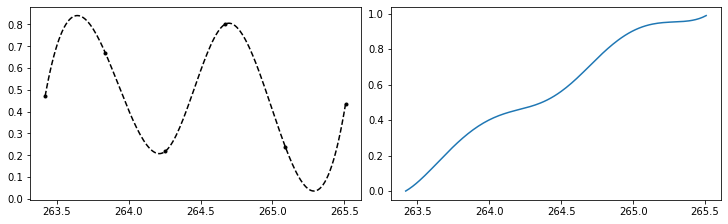

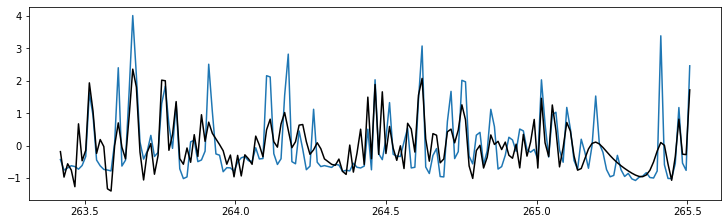

In [29]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best,1:], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
for i, res in enumerate(res_ensemble):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)

    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])

    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
#     axs[1].plot(depth, time-func_time_nominal(depth)+func_time_nominal(depth[0]), color=cmap(i/N_ensemble))
# axs[0].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]), color="black")
axs[1].plot(depth, depth*0, color="k")

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black")
# i = -15
i = -4
res = res_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
depth_genes = depth_genes_ensemble[i]

invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])

ax = axs[0]
print(res.X[arg_best,0]/arcsec_to_pi/1e6, p0//arcsec_to_pi/1e6)

print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best,1:], '.', color="black")
ax = axs[1]
ax.plot(depth, time)
# ax.set_ylim(invSR_lims)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

ax.plot(depth, y )
ax.plot(depth, y_pred, color="black")
print(r2_score(y, y_pred))
# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

### Test2

In [112]:
algorithm = NSGA2(
    pop_size=300,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 500
termination = get_termination("n_gen", N_generations)

# N_genes_enemble = np.arange(10, 60, 4)
N_genes_enemble = np.array([3]*64)
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
N_ensemble = len(depth_genes_ensemble)
fsp = np.hstack([g_k, fe_k])

# N_trial = 4
# N_genes_distinct = np.arange(2, 60, 2)
# N_genes_enemble = np.array([ np.array([i]*N_trial)  for i in  N_genes_distinct]).flatten()
# depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1],N_genes) for N_genes in N_genes_enemble] 

# N_ensemble = len(depth_genes_ensemble)


problems = [invSR_p0_inference_constrained(depth_genes, invSR_lims, p0_lims, interpolator, data, fsp, n_pieces=n_pieces, metric=metric_piecewise_short) for depth_genes in depth_genes_ensemble  ] 

n_procs = len(problems)
# n_procs = 64

res_ensemble = Parallel(n_jobs=n_procs, verbose=100)(delayed(minimize)(problem, algorithm, termination, 
                                                                          save_history=False, callback=Callback_getF())
                                                        for problem in problems)

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])
ind_sort = np.argsort(opt_max_ensemble[:,-1])
res_ensemble = [res_ensemble[i] for i in  ind_sort]
opt_max_ensemble = opt_max_ensemble[ind_sort]

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done   2 out of  64 | elapsed:  3.6min remaining: 110.6min
[Parallel(n_jobs=64)]: Done   3 out of  64 | elapsed:  3.6min remaining: 72.8min
[Parallel(n_jobs=64)]: Done   4 out of  64 | elapsed:  3.6min remaining: 53.8min
[Parallel(n_jobs=64)]: Done   5 out of  64 | elapsed:  3.6min remaining: 43.0min
[Parallel(n_jobs=64)]: Done   6 out of  64 | elapsed:  3.7min remaining: 35.3min
[Parallel(n_jobs=64)]: Done   7 out of  64 | elapsed:  3.7min remaining: 29.8min
[Parallel(n_jobs=64)]: Done   8 out of  64 | elapsed:  3.7min remaining: 25.7min
[Parallel(n_jobs=64)]: Done   9 out of  64 | elapsed:  3.7min remaining: 22.4min
[Parallel(n_jobs=64)]: Done  10 out of  64 | elapsed:  3.7min remaining: 19.8min
[Parallel(n_jobs=64)]: Done  11 out of  64 | elapsed:  3.7min remaining: 17.7min
[Parallel(n_jobs=64)]: Done  12 out of  64 | elaps

a

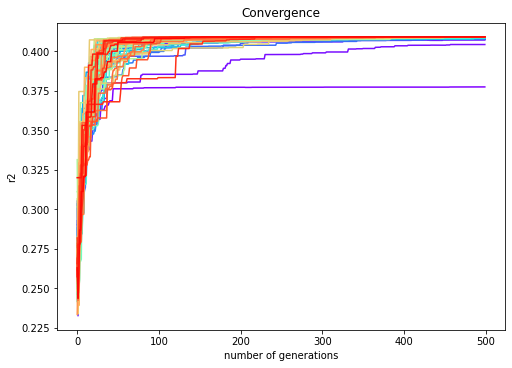

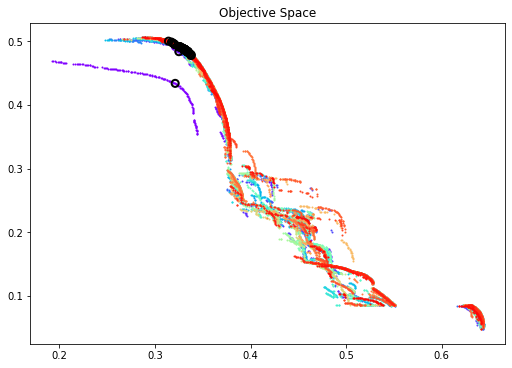

In [114]:

# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(7,5))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
# plt.subplot(1,1,1)

cmap = plt.get_cmap("rainbow")

for i in range(N_ensemble):

    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))

plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.8])
# plt.axhline(metric_optimal.mean(), color="k")


fig = plt.figure(constrained_layout=True, figsize=(7,5))

for i in range(N_ensemble):
    res = res_ensemble[i]
    plt.scatter(-res.F[:, 0], -res.F[:, 1], s=1, color=cmap(i/N_ensemble))
    arg_best = np.argmin(res.F.sum(axis=1))
    plt.scatter(-res.F[arg_best, 0], -res.F[arg_best, 1], marker="o", s=50, color="k", zorder=100,facecolors='none',linewidths=2)
    
f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)
# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


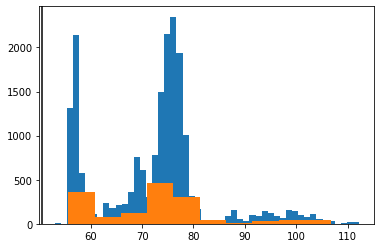

In [115]:
%matplotlib inline
# p0_ensemble = np.hstack([resi.X[:,0] for resi in res_ensemble[-4:] ])
# p0_ensemble.shape
# plt.hist(p0_ensemble/arcsec_to_pi/1e3)
plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[:] ])/arcsec_to_pi/1e6, bins=50)
plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[-5:] ])/arcsec_to_pi/1e6, bins=10)
plt.axvline(p0/arcsec_to_pi/1e6, color="black")
# plt.xlim(*p0_lims/arcsec_to_pi/1e3)
# plt.xlim([45,55])

73.74552163888777 50.467717
[0.3318534  0.48667685]
0.4201710227882386


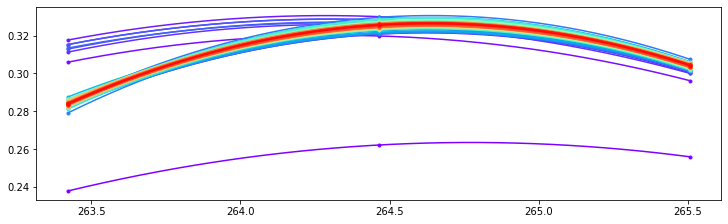

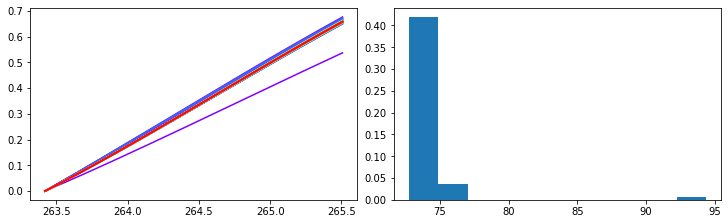

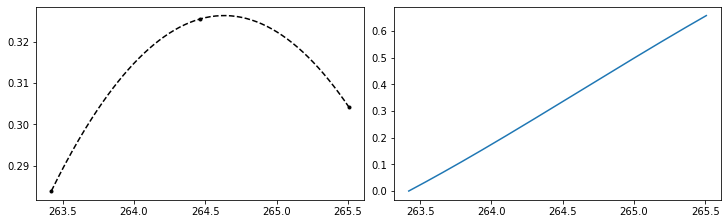

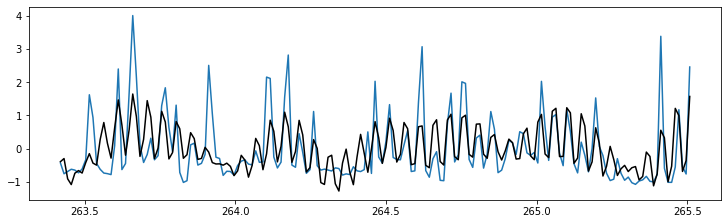

In [116]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble[:]):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best,1:], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
p0s_best = []
for i, res in enumerate(res_ensemble[:]):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
    p0s_best.append(res.X[arg_best,0])
    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])

    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
#     axs[1].plot(depth, time-func_time_nominal(depth)+func_time_nominal(depth[0]), color=cmap(i/N_ensemble))
# axs[0].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]), color="black")
p0s_best = np.array(p0s_best)/arcsec_to_pi/1e6
axs[1].hist(p0s_best, density=True)

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black")
# i = -15
i = -1
res = res_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
depth_genes = depth_genes_ensemble[i]

invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])

ax = axs[0]
print(res.X[arg_best,0]/arcsec_to_pi/1e6, p0//arcsec_to_pi/1e6)

print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best,1:], '.', color="black")
ax = axs[1]
ax.plot(depth, time)
# ax.set_ylim(invSR_lims)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

ax.plot(depth, y )
ax.plot(depth, y_pred, color="black")
print(r2_score(y, y_pred))
# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

In [117]:
n, m = 50, 50
p0_grid = np.linspace(50,100,n)
p0_grid = p0_grid*1/180/3600*np.pi*coef_time
T_grid = np.linspace(0.4, 1, m)
p0_mg, T_mg = np.meshgrid(p0_grid, T_grid)
r2_grid = np.zeros((m, n))

for res in res_ensemble:
    for i_sol in range(res.X.shape[0]):
        # res = res_ensemble[0]
        # i_sol = np.argmin(res.F.mean(axis=1))
        p0i = res.X[i_sol,0]
        reg = linear_model.LinearRegression()
        fs = np.hstack([g_k + p0i, fe_k])
        invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)
        time, y_pred = invSR_to_predx([depth_genes, res.X[i_sol,1:]])
        i = bisect_left(p0_grid, p0i)-1
        j = bisect_left(T_grid, time[-1,])-1
        r2_grid[j,i] = max(r2_score(y, y_pred), r2_grid[j,i])

Text(0, 0.5, 'T [Myr]')

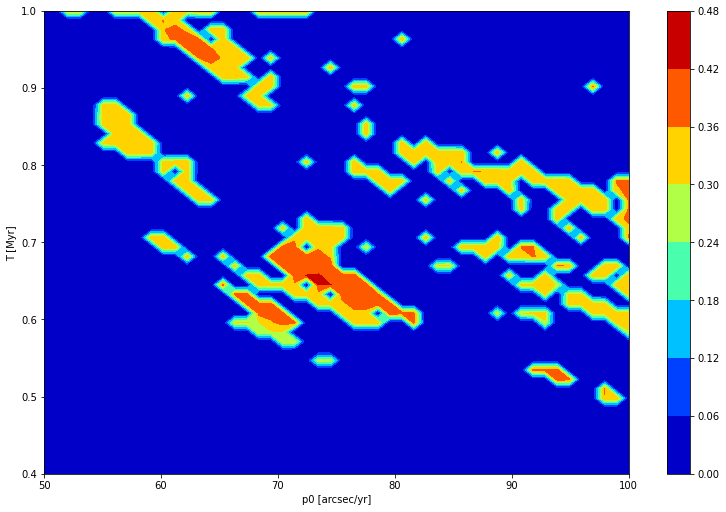

In [118]:
# plt.figure(figsize=(15,10))
fig, ax = plt.subplots(1,1, figsize=(10,7),constrained_layout=True)
plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), T_grid, r2_grid, cmap=plt.cm.jet)
plt.colorbar()

plt.xlabel("p0 [arcsec/yr]")
plt.ylabel("T [Myr]")
# plt.legend()


b

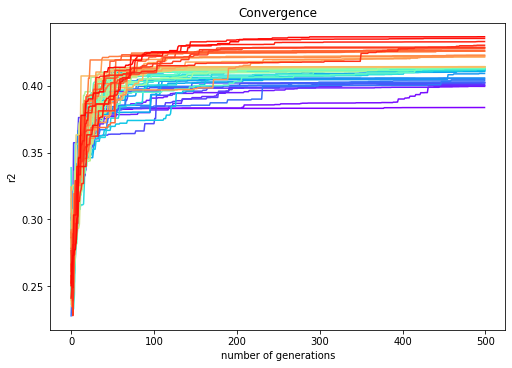

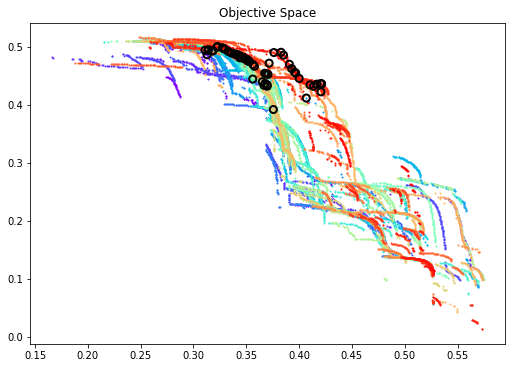

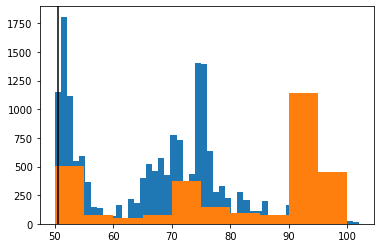

In [108]:

# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(7,5))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
# plt.subplot(1,1,1)

cmap = plt.get_cmap("rainbow")

for i in range(N_ensemble):

    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))

plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.8])
# plt.axhline(metric_optimal.mean(), color="k")


fig = plt.figure(constrained_layout=True, figsize=(7,5))

for i in range(N_ensemble):
    res = res_ensemble[i]
    plt.scatter(-res.F[:, 0], -res.F[:, 1], s=1, color=cmap(i/N_ensemble))
    arg_best = np.argmin(res.F.sum(axis=1))
    plt.scatter(-res.F[arg_best, 0], -res.F[arg_best, 1], marker="o", s=50, color="k", zorder=100,facecolors='none',linewidths=2)
    
f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)
# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


plt.figure()
# p0_ensemble = np.hstack([resi.X[:,0] for resi in res_ensemble[-4:] ])
# p0_ensemble.shape
# plt.hist(p0_ensemble/arcsec_to_pi/1e3)
plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[:] ])/arcsec_to_pi/1e6, bins=50)
plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[-10:] ])/arcsec_to_pi/1e6, bins=10)
plt.axvline(p0/arcsec_to_pi/1e6, color="black")
# plt.xlim(*p0_lims/arcsec_to_pi/1e3)
# plt.xlim([45,55])

97.47836689398282 50.467717
[0.38287851 0.49036611]
0.43990472704175954


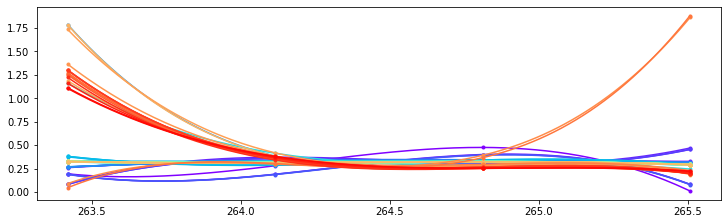

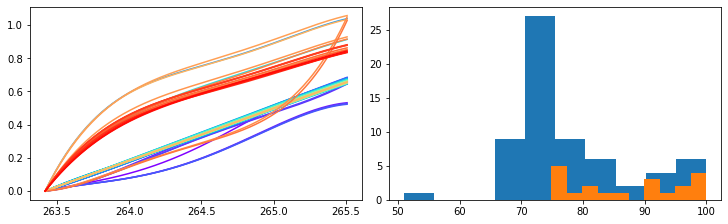

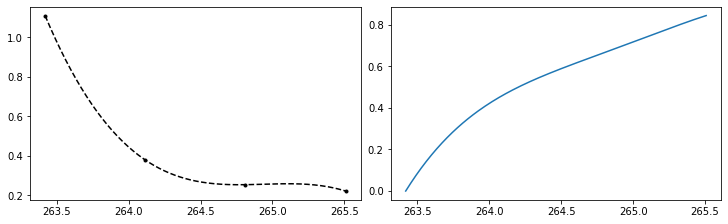

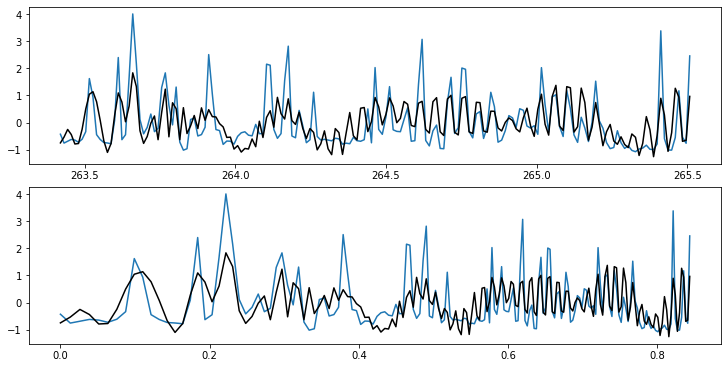

In [109]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble[:]):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    invSR_interpolate = interpolator([depth_genes, res.X[arg_best,1:]], depth)
    invSR_interpolate[invSR_interpolate<invSR_lims[0]] = invSR_lims[0]
    invSR_interpolate[invSR_interpolate>invSR_lims[1]] = invSR_lims[1]
    ax.plot(depth, invSR_interpolate, color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best,1:], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
p0s_best = []
for i, res in enumerate(res_ensemble[:]):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
    p0s_best.append(res.X[arg_best,0])
    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])

    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
#     axs[1].plot(depth, time-func_time_nominal(depth)+func_time_nominal(depth[0]), color=cmap(i/N_ensemble))
# axs[0].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]), color="black")
p0s_best = np.array(p0s_best)/arcsec_to_pi/1e6
axs[1].hist(p0s_best[:])
axs[1].hist(p0s_best[-20:])

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black")
# i = -15
i = -1
res = res_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
depth_genes = depth_genes_ensemble[i]

invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])

ax = axs[0]
print(res.X[arg_best,0]/arcsec_to_pi/1e6, p0//arcsec_to_pi/1e6)

print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best,1:], '.', color="black")
ax = axs[1]
ax.plot(depth, time)
# ax.set_ylim(invSR_lims)

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10,5))
ax = axs[0]
ax.plot(depth, y )
ax.plot(depth, y_pred, color="black")
ax = axs[1]
ax.plot(time, y )
ax.plot(time, y_pred, color="black")

print(r2_score(y, y_pred))
# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

In [110]:
n, m = 50, 50
p0_grid = np.linspace(50,100,n)
p0_grid = p0_grid*1/180/3600*np.pi*coef_time
T_grid = np.linspace(0.4, 1, m)
p0_mg, T_mg = np.meshgrid(p0_grid, T_grid)
r2_grid = np.zeros((m, n))

for res in res_ensemble:
    for i_sol in range(res.X.shape[0]):
        # res = res_ensemble[0]
        # i_sol = np.argmin(res.F.mean(axis=1))
        p0i = res.X[i_sol,0]
        reg = linear_model.LinearRegression()
        fs = np.hstack([g_k + p0i, fe_k])
        invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)
        time, y_pred = invSR_to_predx([depth_genes, res.X[i_sol,1:]])
        i = bisect_left(p0_grid, p0i)-1
        j = bisect_left(T_grid, time[-1,])-1
        r2_grid[j,i] = max(r2_score(y, y_pred), r2_grid[j,i])

Text(0, 0.5, 'T [Myr]')

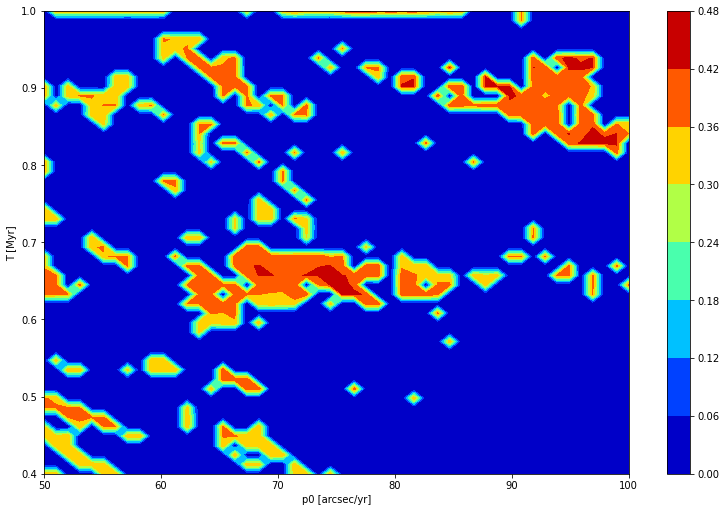

In [111]:
# plt.figure(figsize=(15,10))
fig, ax = plt.subplots(1,1, figsize=(10,7),constrained_layout=True)
plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), T_grid, r2_grid, cmap=plt.cm.jet)
plt.colorbar()

plt.xlabel("p0 [arcsec/yr]")
plt.ylabel("T [Myr]")
# plt.legend()


c

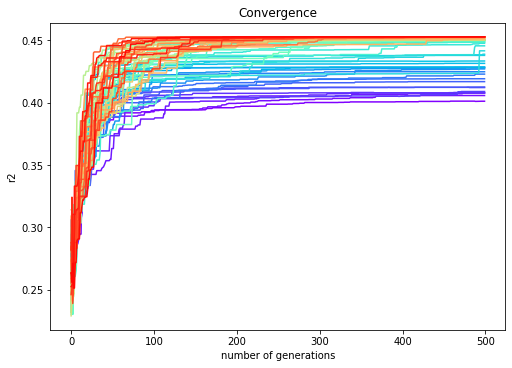

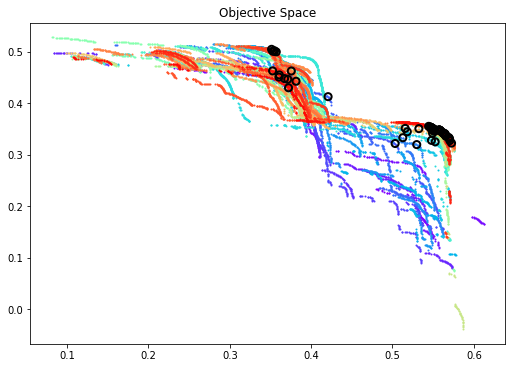

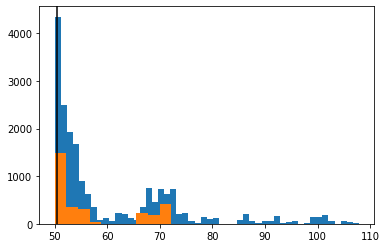

In [51]:

# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(7,5))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
# plt.subplot(1,1,1)

cmap = plt.get_cmap("rainbow")

for i in range(N_ensemble):

    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))

plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.8])
# plt.axhline(metric_optimal.mean(), color="k")


fig = plt.figure(constrained_layout=True, figsize=(7,5))

for i in range(N_ensemble):
    res = res_ensemble[i]
    plt.scatter(-res.F[:, 0], -res.F[:, 1], s=1, color=cmap(i/N_ensemble))
    arg_best = np.argmin(res.F.sum(axis=1))
    plt.scatter(-res.F[arg_best, 0], -res.F[arg_best, 1], marker="o", s=50, color="k", zorder=100,facecolors='none',linewidths=2)
    
f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)
# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


plt.figure()
# p0_ensemble = np.hstack([resi.X[:,0] for resi in res_ensemble[-4:] ])
# p0_ensemble.shape
# plt.hist(p0_ensemble/arcsec_to_pi/1e3)
plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[:] ])/arcsec_to_pi/1e6, bins=50)
plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[-10:] ])/arcsec_to_pi/1e6, bins=10)
plt.axvline(p0/arcsec_to_pi/1e6, color="black")
# plt.xlim(*p0_lims/arcsec_to_pi/1e3)
# plt.xlim([45,55])

50.96416919253303 50.467717
[0.56277126 0.34243481]
0.471591553154325


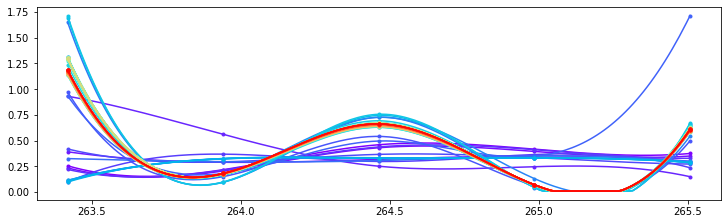

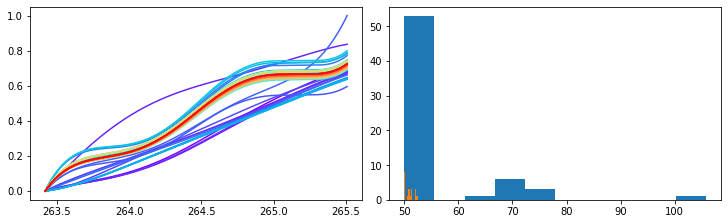

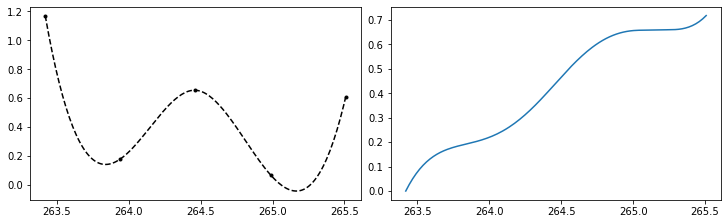

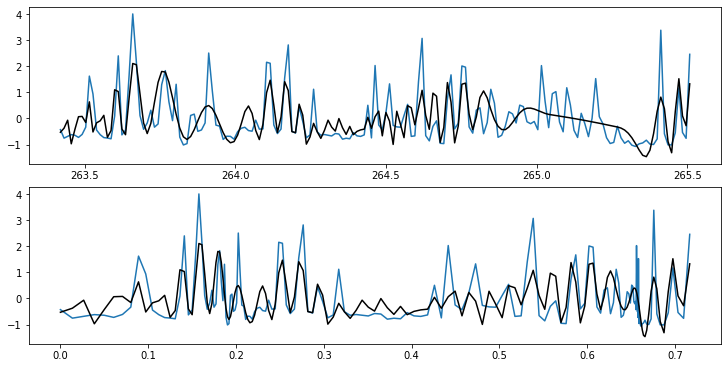

In [54]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble[:]):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    invSR_interpolate = interpolator([depth_genes, res.X[arg_best,1:]], depth)
    invSR_interpolate[invSR_interpolate<invSR_lims[0]] = invSR_lims[0]
    invSR_interpolate[invSR_interpolate>invSR_lims[1]] = invSR_lims[1]
    ax.plot(depth, invSR_interpolate, color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best,1:], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
p0s_best = []
for i, res in enumerate(res_ensemble[:]):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
    p0s_best.append(res.X[arg_best,0])
    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])

    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
#     axs[1].plot(depth, time-func_time_nominal(depth)+func_time_nominal(depth[0]), color=cmap(i/N_ensemble))
# axs[0].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]), color="black")
p0s_best = np.array(p0s_best)/arcsec_to_pi/1e6
axs[1].hist(p0s_best[:])
axs[1].hist(p0s_best[-20:])

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black")
# i = -15
i = -10
res = res_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
depth_genes = depth_genes_ensemble[i]

invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])

ax = axs[0]
print(res.X[arg_best,0]/arcsec_to_pi/1e6, p0//arcsec_to_pi/1e6)

print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best,1:], '.', color="black")
ax = axs[1]
ax.plot(depth, time)
# ax.set_ylim(invSR_lims)

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(10,5))
ax = axs[0]
ax.plot(depth, y )
ax.plot(depth, y_pred, color="black")
ax = axs[1]
ax.plot(time, y )
ax.plot(time, y_pred, color="black")

print(r2_score(y, y_pred))
# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

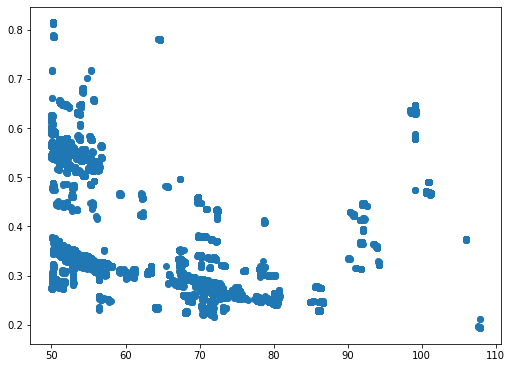

In [57]:
# res_ensemble[-1].X.shape
fig = plt.figure(constrained_layout=True, figsize=(7,5))
resx = np.concatenate([resi.X for resi in res_ensemble[10:] ]) 
# for resi in resx:
# p0i = resi[0]/arcsec_to_pi/1e6
# invSRa = resi[1:].mean()
plt.scatter(resx[:,0]/arcsec_to_pi/1e6, resx[:,1:].mean(axis=-1))

In [103]:
n, m = 50, 50
p0_grid = np.linspace(50,100,n)
p0_grid = p0_grid*1/180/3600*np.pi*coef_time
T_grid = np.linspace(0.4, 1, m)
p0_mg, T_mg = np.meshgrid(p0_grid, T_grid)
r2_grid = np.zeros((m, n))
for res in res_ensemble:
    for i_sol in range(res.X.shape[0]):
        # res = res_ensemble[0]
        # i_sol = np.argmin(res.F.mean(axis=1))
        p0i = res.X[i_sol,0]
        reg = linear_model.LinearRegression()
        fs = np.hstack([g_k + p0i, fe_k])
        invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)
        time, y_pred = invSR_to_predx([depth_genes, res.X[i_sol,1:]])
        i = bisect_left(p0_grid, p0i)-1
        j = bisect_left(T_grid, time[-1,])-1
        r2_grid[j,i] = max(r2_score(y, y_pred), r2_grid[j,i])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


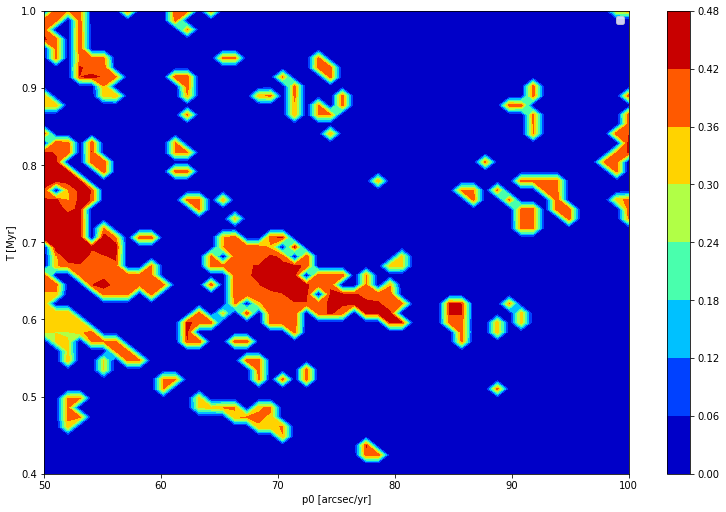

In [106]:
# plt.figure(figsize=(15,10))
fig, ax = plt.subplots(1,1, figsize=(10,7),constrained_layout=True)
plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), T_grid, r2_grid, cmap=plt.cm.jet)
plt.colorbar()
# plt.scatter(p0_grid[j_best]/(1/180/3600*np.pi*coef_time), T_grid[i_best], s=50, color="k", label="best")
# plt.scatter(85.8, 1/3.5, marker="d", s=50, color="k",label="Meyer's value")
# plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2_grid)
# plt.xlabel("")
# rect = Rectangle((78-14,0.2),14*2,0.2,linewidth=2,edgecolor='k',facecolor='none', label="Meyer's range")
# ax.add_patch(rect)

plt.xlabel("p0 [arcsec/yr]")
plt.ylabel("T [Myr]")
plt.legend()
# plt.ax
# plt.contour(p0_grid/(1/180/3600*np.pi*coef_time), invSR_grid, r2_grid)
# plt.axis('scaled')
# plt.savefig("Xiamaling/constantSR.png",dpi=300)

# Spectrum

In [66]:
res.X[arg_best,0 ], p0

(356.6610034747867, 244.67440140777987)

In [67]:
# xf = np.arange(len(times_grid))*2*np.pi*dt/times_grid[-1]

NameError: name 'times_grid' is not defined

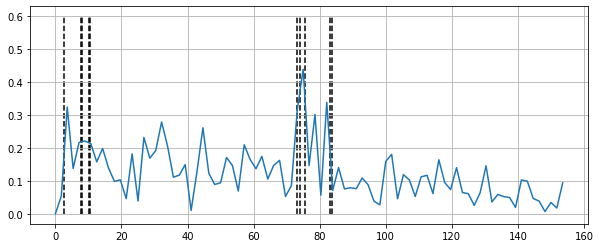

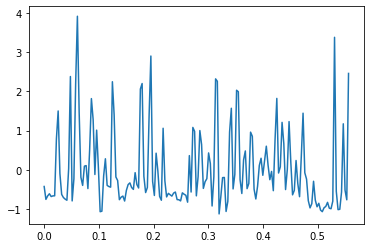

In [68]:
i = 1
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]

arg_best = np.argmin(res.F.mean(axis=1))
invSR_best = res.X[arg_best, 1:]
invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
# invSR_interpolate[invSR_interpolate<invSR_lims[0]] = invSR_lims[0]
# invSR_interpolate[invSR_interpolate>invSR_lims[1]] = invSR_lims[1]
times_inferred = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
fs=np.hstack([g_k+res.X[arg_best,0], fe_k])

ydata_sp = CubicSpline(times_inferred, y)
times_grid = np.linspace(times_inferred[0], times_inferred[-1], len(times_inferred))
N = len(times_grid)
y_equ_spa = ydata_sp(times_grid)

dt = times_grid[1]-times_grid[0]
xf = sp.fft.fftfreq(N, dt)[:N//2]
# xf = np.arange(N)*2*np.pi*dt/times_grid[-1]
yf = sp.fft.fft(y_equ_spa)

plt.figure(figsize=(10,4))
plt.plot(xf, 2.0/N*np.abs(yf[0:N//2]))
# plt.yscale("log")
# plt.xscale("log")
plt.vlines(fs/2/np.pi, 0, 0.6, linestyles="--", colors="black",alpha=1,zorder=-100)
# plt.xlim([30,60])
# plt.xlim([0.04,0.06])
plt.grid()
plt.figure()
plt.plot(times_grid, y_equ_spa)

# plt.vlines(fs[:5]/2/np.pi, 0, 0.6, colors="orange", alpha=0.8)
# plt.xlim([0.03,0.1])
# plt.xlim([0,0.025])
# plt.xlim([50,500])
# plt.xlim([10,50])

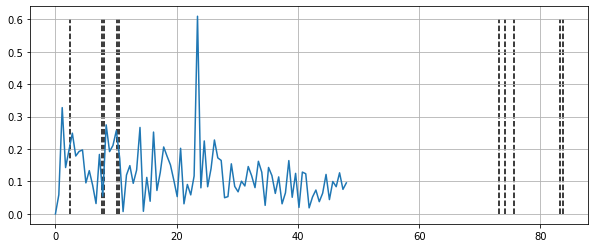

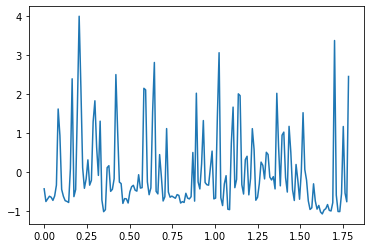

In [176]:
i = 1
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]

arg_best = np.argmin(res.F.mean(axis=1))
invSR_best = res.X[arg_best, 1:]
invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
# invSR_interpolate[invSR_interpolate<invSR_lims[0]] = invSR_lims[0]
# invSR_interpolate[invSR_interpolate>invSR_lims[1]] = invSR_lims[1]
times_inferred = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
fs=np.hstack([g_k+res.X[arg_best,0], fe_k])

ydata_sp = CubicSpline(times_inferred, y)
times_grid = np.linspace(times_inferred[0], times_inferred[-1], len(times_inferred))
N = len(times_grid)
y_equ_spa = ydata_sp(times_grid)

dt = times_grid[1]-times_grid[0]
xf = sp.fft.fftfreq(N, dt)[:N//2]
# xf = np.arange(N)*2*np.pi*dt/times_grid[-1]
yf = sp.fft.fft(y_equ_spa)

plt.figure(figsize=(10,4))
plt.plot(xf, 2.0/N*np.abs(yf[0:N//2]))
# plt.yscale("log")
# plt.xscale("log")
plt.vlines(fs/2/np.pi, 0, 0.6, linestyles="--", colors="black",alpha=1,zorder=-100)
# plt.xlim([30,60])
# plt.xlim([0.04,0.06])
plt.grid()
plt.figure()
plt.plot(times_grid, y_equ_spa)

# plt.vlines(fs[:5]/2/np.pi, 0, 0.6, colors="orange", alpha=0.8)
# plt.xlim([0.03,0.1])
# plt.xlim([0,0.025])
# plt.xlim([50,500])
# plt.xlim([10,50])

In [201]:
i = 1
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
invSR_best = res.X[arg_best, 1:]
depth_hr = np.linspace(depth[0],depth[-1],10000)
invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
# invSR_interpolate[invSR_interpolate<invSR_lims[0]] = invSR_lims[0]
# invSR_interpolate[invSR_interpolate>invSR_lims[1]] = invSR_lims[1]
times_inferred = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
fs = np.hstack([g_k, fe_k])
fs[:5] = fs[:5]+res.X[arg_best,0]
X = generate_X_linReg(np.ones_like(fs), fs, times_inferred)
reg_model = LinearRegression().fit(X, y)
y_pred = X @ reg_model.coef_ 

times_inferred_hr = np.linspace(times_inferred[0], times_inferred[-1], 10000)
# times_inferred = times_inferred_hr
X_prec = generate_X_linReg(np.ones_like(fs[:5]), fs[:5], times_inferred_hr)
X_ecc = generate_X_linReg(np.ones_like(fs[5:]), fs[5:], times_inferred_hr)
X = generate_X_linReg(np.ones_like(fs), fs, times_inferred_hr)

AB_prec = np.hstack([reg_model.coef_[:5], reg_model.coef_[len(fs):len(fs)+5]])
AB_ecc = np.hstack([reg_model.coef_[5:len(fs)], reg_model.coef_[len(fs)+5:]])
# y_pred = reg_model.predict(X)
y_pred_prec = X_prec @ AB_prec
y_pred_ecc = X_ecc @ AB_ecc
y_pred_hr = X @ reg_model.coef_ 

# sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)

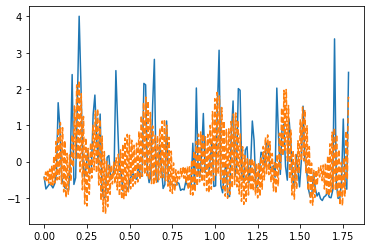

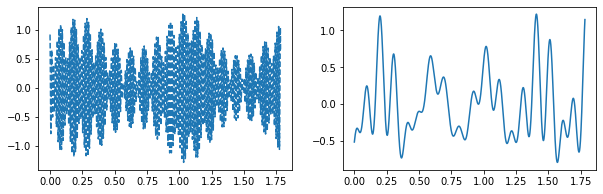

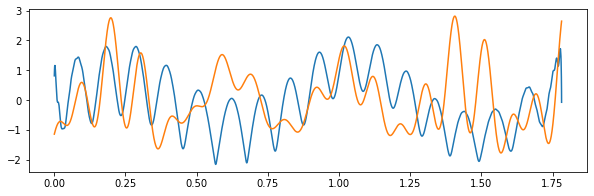

In [204]:
plt.plot(times_inferred, y)
# plt.plot(times_inferred_hr, y_pred_hr, "--")

plt.plot(times_inferred_hr, y_pred_hr, "--")
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(times_inferred_hr, y_pred_prec, "--")
plt.subplot(1,2,2)
plt.plot(times_inferred_hr, y_pred_ecc)

plt.figure(figsize=(10,3))
y_envelope = abs(sp.signal.hilbert(y_pred_prec))
# y_envelope = (y_envelope-y_envelope.mean())/y_envelope.std()
y_envelope_norm = (y_envelope-y_envelope.mean())/y_envelope.std()
y_pred_ecc_norm = (y_pred_ecc-y_pred_ecc.mean())/y_pred_ecc.std()
plt.plot(times_inferred_hr, y_envelope_norm)
plt.plot(times_inferred_hr, y_pred_ecc_norm)
# plt.plot(times_inferred, y_ecc, "--", color="black")

# plt.plot(times, y_pred_ecc, "--")